# Notebook for the project on Federated Learning - Brain Tunors MRI Dataset

In [1]:
# Setting up (imports, seeds, paths, etc)

from pathlib import Path
import os, random
from collections import Counter, defaultdict
import numpy as np

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# This notebook sits in: KI_PROJECT / Jupyter-notebooks
# Data sits in:         KI_PROJECT / data / {Training, Testing}
# So DATA_ROOT is one level up from the notebook, inside 'data'
PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "Jupyter-notebooks") else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data"

TRAIN_DIR = DATA_ROOT / "Training"
TEST_DIR  = DATA_ROOT / "Testing"

# Canonical class order (keep this constant everywhere)
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]
LABEL_MAP   = {c: i for i, c in enumerate(CLASS_NAMES)}

# Supported image extensions
IMG_EXTS = {".jpg", ".jpeg", ".png"}

def is_image_file(p: Path) -> bool:
    return p.is_file() and (p.suffix.lower() in IMG_EXTS)

print("PROJECT_ROOT:", PROJECT_ROOT.resolve())
print("DATA_ROOT   :", DATA_ROOT.resolve())
print("TRAIN_DIR   :", TRAIN_DIR.resolve())
print("TEST_DIR    :", TEST_DIR.resolve())
print("Classes     :", CLASS_NAMES)

PROJECT_ROOT: C:\Users\Htet Wai Aung\GitHub\KI_project
DATA_ROOT   : C:\Users\Htet Wai Aung\GitHub\KI_project\data
TRAIN_DIR   : C:\Users\Htet Wai Aung\GitHub\KI_project\data\Training
TEST_DIR    : C:\Users\Htet Wai Aung\GitHub\KI_project\data\Testing
Classes     : ['glioma', 'meningioma', 'notumor', 'pituitary']


In [2]:
# --- Collect images + labels and sanity checks ---

def collect_images_and_labels(split_dir: Path):
    image_paths, labels = [], []
    for cls in CLASS_NAMES:
        cls_dir = split_dir / cls
        if not cls_dir.exists():
            raise FileNotFoundError(f"Missing class folder: {cls_dir}")
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if is_image_file(p):
                image_paths.append(p)
                labels.append(LABEL_MAP[cls])
    return image_paths, labels

train_images, train_labels = collect_images_and_labels(TRAIN_DIR)
test_images,  test_labels  = collect_images_and_labels(TEST_DIR)

print(f"Total training images: {len(train_images)}")
print(f"Total testing  images: {len(test_images)}")

# Per-class counts for training
train_counts = Counter([CLASS_NAMES[y] for y in train_labels])
print("Training counts per class:", dict(train_counts))

# Peek a few samples
for i in range(min(5, len(train_images))):
    print(f"[Sample {i}] {train_images[i].name:30s} -> {CLASS_NAMES[train_labels[i]]}")

# Existence check
missing = [str(p) for p in train_images + test_images if not p.exists()]
print("Missing files:", len(missing))

Total training images: 5712
Total testing  images: 1311
Training counts per class: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
[Sample 0] Tr-glTr_0000.jpg               -> glioma
[Sample 1] Tr-glTr_0001.jpg               -> glioma
[Sample 2] Tr-glTr_0002.jpg               -> glioma
[Sample 3] Tr-glTr_0003.jpg               -> glioma
[Sample 4] Tr-glTr_0004.jpg               -> glioma
Missing files: 0


In [3]:
# --- Client builders (IID + Non-IID/Dirichlet) and per-client train/val/test ---

from sklearn.model_selection import train_test_split

def safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED):
    """Stratified where possible; falls back safely if a client has sparse classes."""
    if not pairs:
        return {'train': [], 'val': [], 'test': []}
    X, y = zip(*pairs)

    def _try_split(X, y, size, strat=True):
        try:
            return train_test_split(X, y, test_size=size, random_state=seed,
                                    stratify=y if strat else None)
        except ValueError:
            return train_test_split(X, y, test_size=size, random_state=seed, stratify=None)

    X_tr, X_te, y_tr, y_te = _try_split(X, y, test_size, strat=True)
    val_ratio = val_size / (1.0 - test_size)
    X_tr, X_va, y_tr, y_va = _try_split(X_tr, y_tr, val_ratio, strat=True)

    return {
        'train': list(zip(X_tr, y_tr)),
        'val':   list(zip(X_va, y_va)),
        'test':  list(zip(X_te, y_te)),
    }

def make_iid_clients(image_paths, labels, n_clients=4, seed=SEED):
    """Balanced per class across clients via round-robin after per-class shuffle."""
    rng = np.random.default_rng(seed)
    by_class = defaultdict(list)
    for idx, y in enumerate(labels):
        by_class[y].append(idx)
    for y in by_class:
        rng.shuffle(by_class[y])

    buckets = [[] for _ in range(n_clients)]
    for idxs in by_class.values():
        for i, idx in enumerate(idxs):
            buckets[i % n_clients].append(idx)

    clients = {cid: [] for cid in range(n_clients)}
    for cid in range(n_clients):
        for idx in buckets[cid]:
            clients[cid].append((image_paths[idx], labels[idx]))
    return clients

def make_non_iid_clients_dirichlet(
    image_paths, labels, size_weights, alpha=0.3, seed=SEED, min_per_client=1
):
    """
    Non-IID split with controlled client sizes that:
      - yields one large / one small client (via size_weights),
      - forces 'notumor' to be the top class in every client and keeps its % similar across clients,
      - encourages different tumor classes to be the 2nd-highest per client (non-IID in tumors).

    Same API as before.
    """
    import numpy as np
    from collections import defaultdict, Counter

    rng = np.random.default_rng(seed)
    size_weights = np.asarray(size_weights, dtype=float)
    assert np.all(size_weights > 0), "size_weights must be positive"
    n_clients = len(size_weights)

    # --- group by class
    by_class = defaultdict(list)
    for idx, y in enumerate(labels):
        by_class[y].append(idx)
    for y in by_class:  # shuffle inside each class
        rng.shuffle(by_class[y])

    classes = sorted(by_class.keys())
    n_total = len(labels)
    class_counts = {y: len(by_class[y]) for y in classes}

    # --- identify 'notumor' robustly, fallback = global majority
    def _is_notumor_name(name: str) -> bool:
        s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
        return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

    if 'CLASS_NAMES' in globals():
        nt_candidates = [y for y in classes if _is_notumor_name(CLASS_NAMES[y])]
        notumor_label = nt_candidates[0] if nt_candidates else max(class_counts, key=class_counts.get)
    else:
        notumor_label = max(class_counts, key=class_counts.get)

    tumor_labels = [y for y in classes if y != notumor_label]
    assert len(tumor_labels) >= 1, "Need at least one tumor class in addition to notumor."

    # --- target client sizes from weights (one >1000, one <1000 comes from these)
    size_share = size_weights / size_weights.sum()
    target_client_sizes = np.floor(size_share * n_total).astype(int)
    rem = n_total - target_client_sizes.sum()
    if rem > 0:
        for i in rng.choice(n_clients, size=rem, replace=False):
            target_client_sizes[i] += 1

    # --- global proportions
    class_props = {y: class_counts[y] / max(1, n_total) for y in classes}
    p_nt_global = class_props.get(notumor_label, 0.0)

    # --- clamp notumor share per client around global ± tol, and fix totals exactly
    nt_tol = 0.02  # tighten band to ±2% for similar % across clients
    p_nt_low  = max(0.0, p_nt_global - nt_tol)
    p_nt_high = min(1.0, p_nt_global + nt_tol)

    # First, compute per-client target notumor counts within the band
    nt_targets = np.rint(np.clip(p_nt_global, p_nt_low, p_nt_high) * target_client_sizes).astype(int)
    # Adjust to match global notumor total exactly
    nt_total = class_counts[notumor_label]
    diff = nt_total - int(nt_targets.sum())
    if diff != 0:
        # add/remove 1 to clients with largest positive/negative "need" based on gap to exact p_nt_global
        desired = p_nt_global * target_client_sizes
        gaps = desired - nt_targets
        order = np.argsort(gaps)[::-1] if diff > 0 else np.argsort(gaps)  # add where gap biggest; remove where smallest
        for i in order[:abs(diff)]:
            nt_targets[i] += 1 if diff > 0 else -1
            # keep non-negative and <= client size
            nt_targets[i] = max(0, min(nt_targets[i], target_client_sizes[i]))

    # --- remaining capacity per client goes to tumors
    cap_rem = target_client_sizes - nt_targets
    cap_rem = np.maximum(cap_rem, 0)
    tumor_total = n_total - nt_total
    assert tumor_total == int(cap_rem.sum()), "Remaining capacity must equal total tumor images."

    # --- per-client tumor preference: rotate 2nd-highest across clients
    # soft boosts to encourage (cid 0 -> tumor_labels[0], cid 1 -> tumor_labels[1], ...)
    tumor_pref = {cid: {y: 1.0 for y in tumor_labels} for cid in range(n_clients)}
    for cid in range(n_clients):
        y_pref = tumor_labels[cid % len(tumor_labels)]
        tumor_pref[cid][y_pref] = 1.20  # 20% soft boost for this client's tumor
        for y in tumor_labels:
            if y != y_pref:
                tumor_pref[cid][y] = 0.95

    # --- initial tumor allocation (counts) by proportional fit with jitter + preference
    alloc = {cid: {y: 0 for y in classes} for cid in range(n_clients)}
    for cid in range(n_clients):
        alloc[cid][notumor_label] = int(nt_targets[cid])

    conc_scale = max(1e-3, 1.0 / max(alpha, 1e-6))  # smaller alpha -> tighter around base
    base = (cap_rem / max(1, cap_rem.sum())).astype(float)

    for y in tumor_labels:
        k = class_counts[y]
        if k == 0:
            continue
        # Base shares for this tumor ~ remaining capacities
        base_shares = base.copy()
        # Jitter around base_shares
        conc = np.where(base_shares > 0, base_shares * conc_scale * n_clients, 1e-3)
        jitter = rng.dirichlet(conc)
        props = 0.7 * base_shares + 0.3 * jitter  # mostly base by capacity

        # apply client-specific preference for the chosen 2nd-highest tumor
        for cid in range(n_clients):
            props[cid] *= tumor_pref[cid].get(y, 1.0)

        # respect each client's remaining cap
        # (normalize within feasible caps)
        feasible = np.array([max(0, cap_rem[cid]) for cid in range(n_clients)], dtype=float)
        feasible_sum = feasible.sum()
        if feasible_sum == 0:
            # no capacity left anywhere; skip
            continue
        props = props * feasible
        if props.sum() == 0:
            # fall back to feasible-only
            props = feasible / feasible_sum
        else:
            props = props / props.sum()

        raw = np.floor(props * k).astype(int)
        r = k - raw.sum()

        # ensure we don't exceed remaining capacities
        for cid in range(n_clients):
            raw[cid] = min(raw[cid], max(0, cap_rem[cid]))
        r = k - raw.sum()

        # distribute remainders greedily to clients with remaining capacity
        if r > 0:
            order = np.argsort(-props)  # highest prop first
            for cid in order:
                take = min(r, max(0, cap_rem[cid] - raw[cid]))
                if take > 0:
                    raw[cid] += take
                    r -= take
                if r == 0:
                    break

        # commit and update caps
        for cid in range(n_clients):
            alloc[cid][y] += int(raw[cid])
            cap_rem[cid] -= int(raw[cid])

    # --- balance tiny mismatches in per-class totals due to caps/rounding
    # fix per-class sums to match exactly
    for y in classes:
        need = class_counts[y] - sum(alloc[cid][y] for cid in range(n_clients))
        if need == 0:
            continue
        if need > 0:
            # add where client still has spare (only possible if notumor took less than target_client_sizes)
            order = list(range(n_clients))
            rng.shuffle(order)
            for cid in order:
                spare = target_client_sizes[cid] - sum(alloc[cid][z] for z in classes)
                if spare <= 0:
                    continue
                take = min(spare, need)
                alloc[cid][y] += take
                need -= take
                if need == 0:
                    break
        else:
            # remove excess from clients with that class
            give = -need
            order = list(range(n_clients))
            rng.shuffle(order)
            for cid in order:
                if alloc[cid][y] == 0:
                    continue
                rm = min(alloc[cid][y], give)
                alloc[cid][y] -= rm
                give -= rm
                if give == 0:
                    break

    # --- ensure per-client totals exactly match target_client_sizes
    def client_total(cid): return sum(alloc[cid][z] for z in classes)
    for _ in range(4 * n_clients):
        deltas = [client_total(cid) - target_client_sizes[cid] for cid in range(n_clients)]
        if all(d == 0 for d in deltas):
            break
        donors = [cid for cid, d in enumerate(deltas) if d > 0]
        receivers = [cid for cid, d in enumerate(deltas) if d < 0]
        if not donors or not receivers:
            break
        rng.shuffle(donors); rng.shuffle(receivers)
        for d_cid in donors:
            for r_cid in receivers:
                if client_total(d_cid) <= target_client_sizes[d_cid]:
                    break
                if client_total(r_cid) >= target_client_sizes[r_cid]:
                    continue
                # Prefer moving tumor classes (not notumor) to keep nt stable
                move_class = None
                pref = sorted(tumor_labels, key=lambda y: alloc[d_cid][y] - alloc[r_cid][y], reverse=True) + [notumor_label]
                for y in pref:
                    if alloc[d_cid][y] > 0:
                        move_class = y; break
                if move_class is None:
                    continue
                alloc[d_cid][move_class] -= 1
                alloc[r_cid][move_class] += 1

    # --- materialize indices per client according to alloc
    clients = {cid: [] for cid in range(n_clients)}
    used_offsets = {y: 0 for y in classes}
    for y in classes:
        idxs = by_class[y]
        for cid in range(n_clients):
            take = int(alloc[cid][y])
            if take <= 0:
                continue
            chosen = idxs[used_offsets[y]:used_offsets[y]+take]
            used_offsets[y] += take
            for idx in chosen:
                clients[cid].append((image_paths[idx], labels[idx]))

    # --- REPAIR PASS A: enforce 'notumor' majority + similar % band strictly
    def per_client_counts(cid):
        return Counter(lbl for _, lbl in clients[cid])

    def ensure_notumor_majority_and_band(max_iters=6*n_clients):
        # swap one tumor<->notumor between clients when needed
        for _ in range(max_iters):
            bad = []
            good = []
            for cid in range(n_clients):
                cnt = per_client_counts(cid)
                tot = sum(cnt.values())
                nt = cnt.get(notumor_label, 0)
                max_other = max([cnt[t] for t in tumor_labels] or [0])
                p = nt / max(1, tot)
                maj_ok = nt > max_other
                band_ok = (p >= p_nt_low) and (p <= p_nt_high)
                if maj_ok and band_ok:
                    good.append(cid)
                else:
                    bad.append((cid, nt, max_other, p, tot, cnt))
            if not bad:
                return
            for (cid, nt, max_other, p, tot, cnt) in bad:
                # need +1 notumor here if possible
                donors = []
                for d in good:
                    dcnt = per_client_counts(d)
                    if dcnt.get(notumor_label, 0) > 0:
                        # giving 1 keeps donor majority?
                        after_nt = dcnt[notumor_label] - 1
                        after_max_other = max([dcnt[t] for t in tumor_labels] or [0])
                        if after_nt > after_max_other:
                            donors.append(d)
                if not donors:
                    continue
                d = donors[rng.integers(len(donors))]
                # take 1 notumor from donor d, give back receiver's largest tumor (to keep totals)
                # find concrete indices to swap
                # pull any notumor sample idx from donor
                donor_nt_idx = next(i for i,(pth,lbl) in enumerate(clients[d]) if lbl == notumor_label)
                # choose receiver's largest tumor class
                rcnt = per_client_counts(cid)
                tumor_back = max(tumor_labels, key=lambda t: rcnt.get(t,0)) if tumor_labels else None
                if tumor_back is None or rcnt.get(tumor_back,0) == 0:
                    continue
                recv_tumor_idx = next(i for i,(pth,lbl) in enumerate(clients[cid]) if lbl == tumor_back)
                # swap
                clients[cid][recv_tumor_idx], clients[d][donor_nt_idx] = clients[d][donor_nt_idx], clients[cid][recv_tumor_idx]
        # end for
    ensure_notumor_majority_and_band()

    # --- REPAIR PASS B: push distinct "2nd-highest tumor" across clients
    # if duplicates remain, nudge by swapping a few tumor samples between clients
    def second_highest_tumor(cid):
        cnt = per_client_counts(cid)
        # rank tumors only
        tum_pairs = sorted([(t, cnt.get(t,0)) for t in tumor_labels], key=lambda x: x[1], reverse=True)
        return tum_pairs[0][0] if tum_pairs else None

    # Try to de-duplicate second-highest labels
    for _ in range(3 * n_clients):
        seconds = [second_highest_tumor(cid) for cid in range(n_clients)]
        freq = Counter(seconds)
        dup_labels = [t for t,c in freq.items() if t is not None and c > 1]
        if not dup_labels:
            break
        # For any duplicated tumor label, try to swap one sample so a client switches runner-up
        for t in dup_labels:
            cids_with_t = [cid for cid in range(n_clients) if seconds[cid] == t]
            if len(cids_with_t) < 2:
                continue
            # pick a receiver that could flip by losing 1 sample of t and gaining another tumor
            cid_a = cids_with_t[0]
            # choose alternative tumor to boost
            alt_list = [u for u in tumor_labels if u != t]
            if not alt_list:
                continue
            alt = alt_list[rng.integers(len(alt_list))]
            # find donor client that has spare 'alt' and can give without breaking nt majority
            donors = []
            for d in range(n_clients):
                if d == cid_a:
                    continue
                dcnt = per_client_counts(d)
                if dcnt.get(alt,0) > 0:
                    # ensure donor keeps nt majority if we take nothing of nt (we'll swap tumor<->tumor)
                    donors.append(d)
            if not donors:
                continue
            d = donors[rng.integers(len(donors))]
            # perform a tumor<->tumor swap: (cid_a gets 'alt', donor gets 't')
            try:
                idx_alt_d = next(i for i,(pth,lbl) in enumerate(clients[d]) if lbl == alt)
                idx_t_a   = next(i for i,(pth,lbl) in enumerate(clients[cid_a]) if lbl == t)
            except StopIteration:
                continue
            clients[cid_a][idx_t_a], clients[d][idx_alt_d] = clients[d][idx_alt_d], clients[cid_a][idx_t_a]
        # loop more than once if needed

    return clients

def summarize_clients(clients_dict, title):
    print(f"\n=== {title} ===")
    for cid, pairs in clients_dict.items():
        counts = Counter(CLASS_NAMES[y] for _, y in pairs)
        print(f"Client {cid}: {len(pairs)} samples | per-class: {dict(counts)}")

# Build clients both ways
clients_iid    = make_iid_clients(train_images, train_labels, n_clients=4, seed=SEED)
# desired client size pattern: [Large, Small, Medium, Medium]
size_weights = [2.5, 1.2, 2, 2]   # Size adjustements for Non-IID

clients_noniid = make_non_iid_clients_dirichlet(
    train_images, train_labels,
    size_weights=size_weights,
    alpha=0.7,          # lower alpha => more non-IID per class
    seed=SEED,
    min_per_client=1
)

summarize_clients(clients_iid,    "IID (equal-ish) training distribution")
summarize_clients(clients_noniid, "Non-IID (weighted, alpha=0.3) training distribution")

# Per-client train/val/test splits
clients_iid_splits    = {cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED)
                         for cid, pairs in clients_iid.items()}
clients_noniid_splits = {
    cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED)
    for cid, pairs in clients_noniid.items()
}



=== IID (equal-ish) training distribution ===
Client 0: 1430 samples | per-class: {'glioma': 331, 'meningioma': 335, 'notumor': 399, 'pituitary': 365}
Client 1: 1428 samples | per-class: {'glioma': 330, 'meningioma': 335, 'notumor': 399, 'pituitary': 364}
Client 2: 1428 samples | per-class: {'glioma': 330, 'meningioma': 335, 'notumor': 399, 'pituitary': 364}
Client 3: 1426 samples | per-class: {'glioma': 330, 'meningioma': 334, 'notumor': 398, 'pituitary': 364}

=== Non-IID (weighted, alpha=0.3) training distribution ===
Client 0: 1855 samples | per-class: {'pituitary': 465, 'glioma': 467, 'meningioma': 436, 'notumor': 487}
Client 1: 890 samples | per-class: {'glioma': 83, 'meningioma': 226, 'notumor': 273, 'pituitary': 308}
Client 2: 1484 samples | per-class: {'pituitary': 261, 'glioma': 391, 'notumor': 417, 'meningioma': 415}
Client 3: 1483 samples | per-class: {'pituitary': 423, 'glioma': 380, 'meningioma': 262, 'notumor': 418}


In [4]:
#Checking training size
print("\n=== IID splits (counts) ===")
for cid, s in clients_iid_splits.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")

print("\n=== Non-IID splits (counts) ===")
for cid, s in clients_noniid_splits.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")


=== IID splits (counts) ===
Client 0: train=1001 {'meningioma': 234, 'notumor': 279, 'glioma': 232, 'pituitary': 256} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'pituitary': 73, 'notumor': 80, 'glioma': 66, 'meningioma': 67}
Client 1: train=999 {'glioma': 231, 'notumor': 279, 'meningioma': 234, 'pituitary': 255} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}
Client 2: train=999 {'glioma': 231, 'notumor': 279, 'meningioma': 234, 'pituitary': 255} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}
Client 3: train=997 {'pituitary': 254, 'notumor': 278, 'meningioma': 234, 'glioma': 231} | val=143 {'glioma': 33, 'notumor': 40, 'meningioma': 33, 'pituitary': 37} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}

=== Non-I

In [5]:
# Torch Dataset, transforms, and DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError

# Repro settings for torch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4 if device.type == "cuda" else 0
PIN_MEMORY = True if device.type == "cuda" else False

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class BrainTumorDataset(Dataset):
    """Takes a list of (Path, int_label). Safely skips unreadable images via collate_fn."""
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path, label = self.pairs[idx]
        try:
            img = Image.open(path).convert("RGB")
        except (FileNotFoundError, UnidentifiedImageError, OSError):
            # Signal a bad sample; collate_fn will drop it
            return None
        if self.transform is not None:
            img = self.transform(img)
        return img, int(label)

def drop_bad_collate(batch):
    """Filters out None samples from Dataset __getitem__."""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # DataLoader will skip this batch
    imgs, labels = zip(*batch)
    return torch.stack(imgs, dim=0), torch.tensor(labels, dtype=torch.long)

def make_client_loaders(client_splits, batch_size=32):
    """Build train/val/test DataLoaders for one client."""
    ds_train = BrainTumorDataset(client_splits["train"], transform=train_tfms)
    ds_val   = BrainTumorDataset(client_splits["val"],   transform=eval_tfms)
    ds_test  = BrainTumorDataset(client_splits["test"],  transform=eval_tfms)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    dl_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    return dl_train, dl_val, dl_test

print("Device:", device)

Device: cpu


In [6]:
# Local training loop per client (saves best state), then run for all 4 clients ---

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from time import time

NUM_CLASSES = len(CLASS_NAMES)

def make_resnet18(pretrained=True, num_classes=NUM_CLASSES):
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for batch in loader:
        if batch is None:  # possible if all items in a batch were bad
            continue
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    if total == 0:
        return float("inf"), 0.0
    return loss_sum / total, correct / total

def train_local_one_client(client_id, client_splits, epochs=5, batch_size=32, lr=1e-3,
                           pretrained=True, freeze_backbone=False, patience=2):
    """Trains a model on one client's data. Returns best_state_dict and metrics."""
    dl_train, dl_val, dl_test = make_client_loaders(client_splits, batch_size=batch_size)

    model = make_resnet18(pretrained=pretrained, num_classes=NUM_CLASSES).to(device)
    if freeze_backbone:
        for name, p in model.named_parameters():
            if not name.startswith("fc."):
                p.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_val_acc, best_state, epochs_no_improve = 0.0, None, 0
    history = []

    for ep in range(1, epochs + 1):
        model.train()
        total, correct, loss_sum = 0, 0, 0.0
        t0 = time()
        for batch in dl_train:
            if batch is None:
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item() * y.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_loss = loss_sum / max(total, 1)
        train_acc  = correct / max(total, 1)

        val_loss, val_acc = evaluate(model, dl_val, criterion)
        history.append({"epoch": ep, "train_loss": train_loss, "train_acc": train_acc,
                        "val_loss": val_loss, "val_acc": val_acc})
        print(f"[Client {client_id}] Epoch {ep:02d} | "
              f"Train L:{train_loss:.4f} A:{train_acc:.4f} | "
              f"Val L:{val_loss:.4f} A:{val_acc:.4f} | {time()-t0:.1f}s")

        # Early stopping on best val acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[Client {client_id}] Early stopping.")
                break

    # Load best and evaluate on client's test set
    if best_state is not None:
        model.load_state_dict(best_state)
    test_loss, test_acc = evaluate(model, dl_test, criterion)
    print(f"[Client {client_id}] Test  L:{test_loss:.4f} A:{test_acc:.4f}")

    # Return best weights and sample counts (for weighted FedAvg later)
    n_train = len(client_splits["train"])
    return {
        "client_id": client_id,
        "best_state": best_state if best_state is not None else {k: v.cpu().clone() for k, v in model.state_dict().items()},
        "train_samples": n_train,
        "history": history,
        "val_best_acc": best_val_acc,
        "test_acc": test_acc,
    }



## Training, Validation and Testing with IID split (Independent & Identical Distribution)

In [7]:
# ---------- Run local training for all 4 clients ----------
# Choose which split to use:
#   clients_iid_splits    (balanced)
#   clients_noniid_splits (skewed)
ACTIVE_SPLITS = clients_iid_splits   # <-- switch to clients_noniid_splits to test Non-IID

local_results = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=5,                # keep small for quick tests
        batch_size=32,
        lr=1e-3,
        pretrained=True,         # keep consistent across all clients
        freeze_backbone=False,   # set True to tune only the final layer
        patience=2
    )
    local_results[cid] = res

print("\nSummary (best Val Acc / Test Acc):")
for cid, r in local_results.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

[Client 0] Epoch 01 | Train L:0.6045 A:0.7672 | Val L:0.8189 A:0.8462 | 81.2s
[Client 0] Epoch 02 | Train L:0.3832 A:0.8721 | Val L:0.8900 A:0.6573 | 47.4s
[Client 0] Epoch 03 | Train L:0.2261 A:0.9081 | Val L:0.5466 A:0.8252 | 48.5s
[Client 0] Early stopping.
[Client 0] Test  L:0.4812 A:0.9021
[Client 1] Epoch 01 | Train L:0.6461 A:0.7778 | Val L:0.6107 A:0.8252 | 75.7s
[Client 1] Epoch 02 | Train L:0.3587 A:0.8739 | Val L:0.5706 A:0.8042 | 48.3s
[Client 1] Epoch 03 | Train L:0.1993 A:0.9269 | Val L:0.4337 A:0.8601 | 49.4s
[Client 1] Epoch 04 | Train L:0.1615 A:0.9329 | Val L:0.7249 A:0.8042 | 47.7s
[Client 1] Epoch 05 | Train L:0.1628 A:0.9540 | Val L:0.5072 A:0.8462 | 62.1s
[Client 1] Early stopping.
[Client 1] Test  L:0.5080 A:0.8706
[Client 2] Epoch 01 | Train L:0.6125 A:0.7788 | Val L:0.9249 A:0.7203 | 92.9s
[Client 2] Epoch 02 | Train L:0.3670 A:0.8579 | Val L:2.5164 A:0.6154 | 66.8s
[Client 2] Epoch 03 | Train L:0.2774 A:0.8959 | Val L:0.4285 A:0.8531 | 71.6s
[Client 2] Epoch 0

In [8]:
#  Weighted FedAvg -> build global model -> evaluate on Testing

# Reuse: CLASS_NAMES, NUM_CLASSES, eval_tfms, BrainTumorDataset, drop_bad_collate, device, TEST_DIR already defined.

def build_global_model(num_classes=NUM_CLASSES, pretrained=True):
    if pretrained:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        m = models.resnet18(weights=None)
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, num_classes)
    return m.to(device)

def fedavg_weighted(global_model, client_state_and_sizes):
    """
    client_state_and_sizes: list of tuples (state_dict, n_train)
    Averages only floating-point params/buffers. Copies non-floating (e.g., Long) from first client.
    """
    if len(client_state_and_sizes) == 0:
        raise ValueError("No client states provided.")

    # Initialize accumulator on CPU for safety
    gdict = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    for k in gdict:
        # Zero only float tensors; leave others as-is for now (we'll overwrite later)
        if torch.is_floating_point(gdict[k]):
            gdict[k].zero_()

    total = 0
    first_state = None

    for state, n in client_state_and_sizes:
        if n <= 0:
            continue
        if first_state is None:
            # Keep a reference to copy non-float tensors from
            first_state = {k: v.detach().cpu() for k, v in state.items()}
        total += n
        for k in gdict:
            src = state[k].detach().cpu()
            if torch.is_floating_point(src):
                gdict[k] += src * float(n)   # weighted sum
            # else: skip here; we’ll copy non-floats after loop

    if total == 0:
        raise ValueError("Total training samples across clients is zero.")

    # Finalize: average floats; copy non-floats from first client
    for k in gdict:
        if torch.is_floating_point(gdict[k]):
            gdict[k] /= float(total)
        else:
            # Copy integer/bool tensors (e.g., num_batches_tracked) from first client
            gdict[k] = first_state[k]

    global_model.load_state_dict(gdict)
    return global_model

@torch.no_grad()
def evaluate_model(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for batch in loader:
        if batch is None:
            continue
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return (loss_sum / total, correct / total) if total > 0 else (float("inf"), 0.0)

# 1) Pack client best states and sample sizes from previous cell
client_state_and_sizes = []
for cid, res in local_results.items():
    client_state_and_sizes.append((res["best_state"], res["train_samples"]))

# 2) Build global model and FedAvg-aggregate
global_model = build_global_model(pretrained=True)
global_model = fedavg_weighted(global_model, client_state_and_sizes)

# 3) Build a global Testing loader (from KI_PROJECT/data/Testing)
def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False,
                         num_workers=0 if device.type=="cpu" else 4,
                         pin_memory=(device.type=="cuda"),
                         persistent_workers=(device.type=="cuda"),
                         collate_fn=drop_bad_collate)

# 4) Evaluate global model on Testing
criterion = nn.CrossEntropyLoss()
g_loss, g_acc = evaluate_model(global_model, test_loader, criterion)
print(f"[Global FedAvg] Test Loss: {g_loss:.4f}  |  Test Acc: {g_acc:.4f}")

[Global FedAvg] Test Loss: 1.1752  |  Test Acc: 0.4272


In [9]:
# Quick check: evaluate the GLOBAL model on each client's test set
criterion = nn.CrossEntropyLoss()
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model, dl_test, criterion)
    print(f"[Global on Client {cid} test] Loss {loss:.4f}  Acc {acc:.4f}")

[Global on Client 0 test] Loss 1.1642  Acc 0.4476
[Global on Client 1 test] Loss 1.1737  Acc 0.4371
[Global on Client 2 test] Loss 1.1754  Acc 0.4441
[Global on Client 3 test] Loss 1.1694  Acc 0.4650


In [10]:
# --- BN recalibration + re-evaluate on Testing ---

from torch.utils.data import ConcatDataset, Subset
import math

def make_calibration_loader(clients_splits, per_client=200, batch_size=64):
    """Take up to `per_client` TRAIN samples from each client to recalibrate BN."""
    cal_pairs = []
    for cid, splits in clients_splits.items():
        take = min(per_client, len(splits["train"]))
        cal_pairs.extend(splits["train"][:take])
    cal_ds = BrainTumorDataset(cal_pairs, transform=eval_tfms)  # no aug
    cal_dl = DataLoader(cal_ds, batch_size=batch_size, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                        persistent_workers=bool(NUM_WORKERS),
                        collate_fn=drop_bad_collate)
    return cal_dl

@torch.no_grad()
def bn_recalibrate(model, cal_loader, max_batches=100):
    """Forward-only in train mode to update BN running stats; no weight updates."""
    was_training = model.training
    model.train()
    seen = 0
    for batch in cal_loader:
        if batch is None: 
            continue
        x, _ = batch
        x = x.to(device)
        _ = model(x)  # updates BN running_mean/var
        seen += 1
        if seen >= max_batches:
            break
    model.train(was_training)

# 1) Build calibration loader from ACTIVE_SPLITS (IID or Non-IID)
cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)

# 2) Recalibrate BN on a few hundred samples
bn_recalibrate(global_model, cal_loader, max_batches=50)

# 3) Re-evaluate global model on the global TEST set
g_loss_fix, g_acc_fix = evaluate_model(global_model, test_loader, criterion)
print(f"[Global FedAvg + BN recal] Test Loss: {g_loss_fix:.4f} | Test Acc: {g_acc_fix:.4f}")

[Global FedAvg + BN recal] Test Loss: 0.6460 | Test Acc: 0.8673


In [11]:
#Aggregate only trainable params; copy BN buffers from the largest client

def fedavg_params_only(global_model, client_state_and_sizes):
    # find largest client (by n)
    largest_idx = max(range(len(client_state_and_sizes)), key=lambda i: client_state_and_sizes[i][1])
    largest_state, _ = client_state_and_sizes[largest_idx]

    gdict = global_model.state_dict()
    # average only tensors that require grad in the model (weights/bias)
    with torch.no_grad():
        # first copy BN buffers from largest client
        for k, v in gdict.items():
            if "running_mean" in k or "running_var" in k or "num_batches_tracked" in k:
                gdict[k].copy_(largest_state[k])
        # now average parameters
        total = sum(n for _, n in client_state_and_sizes)
        for k, v in gdict.items():
            if "running_mean" in k or "running_var" in k or "num_batches_tracked" in k:
                continue
            acc = torch.zeros_like(v)
            for state, n in client_state_and_sizes:
                acc += state[k].to(acc.dtype) * n
            gdict[k].copy_(acc / max(total, 1))
    global_model.load_state_dict(gdict)
    return global_model

In [12]:
# Re-checking the local models after calibration
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model, dl_test, criterion)
    print(f"[After BN recalibrated] Global on Client {cid} test: Acc {acc:.4f}")

[After BN recalibrated] Global on Client 0 test: Acc 0.9231
[After BN recalibrated] Global on Client 1 test: Acc 0.9231
[After BN recalibrated] Global on Client 2 test: Acc 0.9196
[After BN recalibrated] Global on Client 3 test: Acc 0.9301


### Summaries of steps performed for Federated Learning with IDD spiits

1 Setting up the enviroment
2 Collecting and checking the data
3 Split the dataset for FL Clients
4 Creating Data Loaders and Transformations
5 Local training for each client
6 Combine the modesl for a Global Model with FedAvg
7 Global Model Evaluation
8 Fixing Batch Normalization (BN Recalibration)



### Vistualization of results and testing

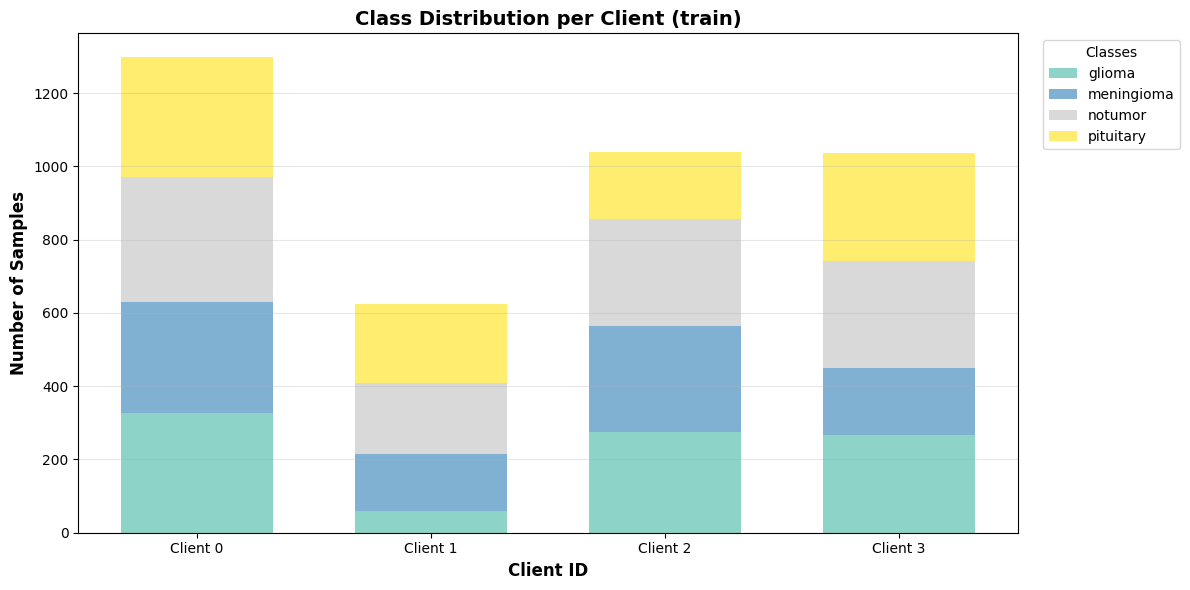

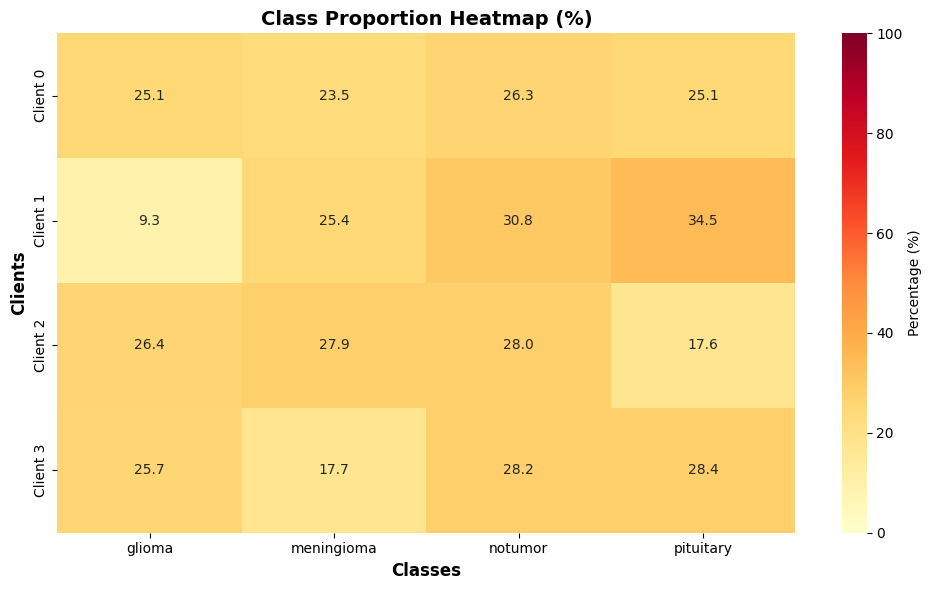

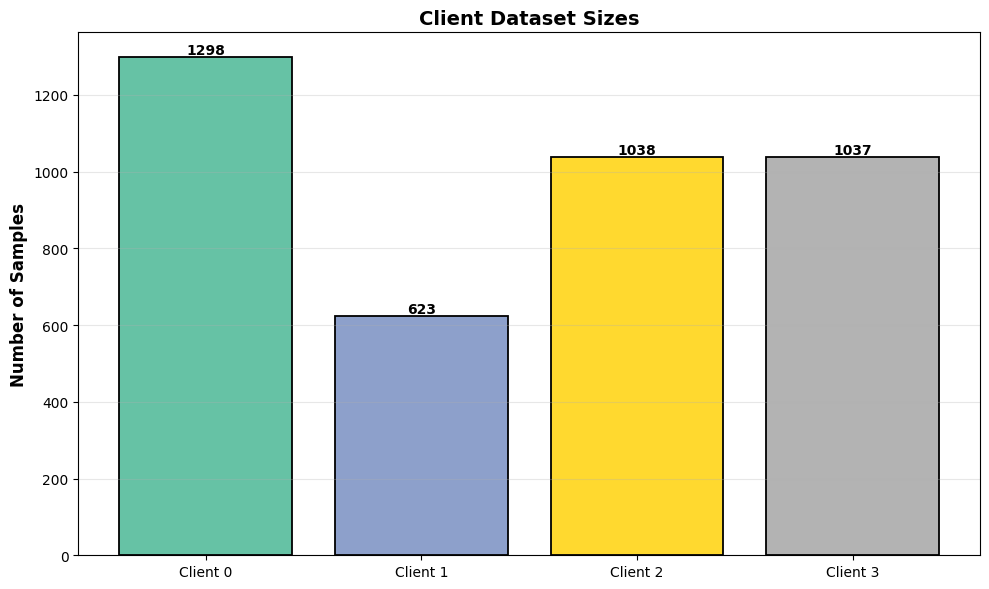

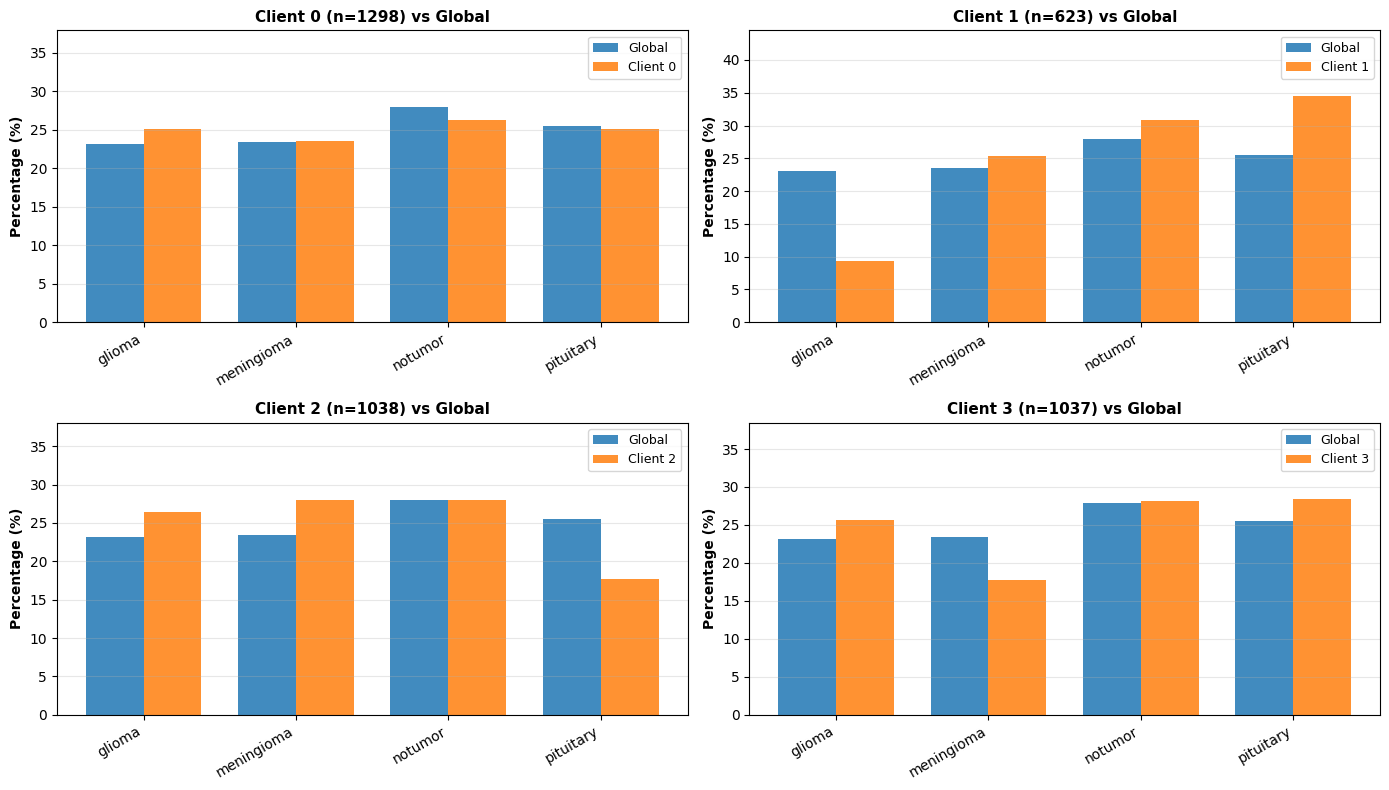


SUMMARY for subset: train

Client 0: 1298 samples
  glioma      :   326  ( 25.1%)
  meningioma  :   305  ( 23.5%)
  notumor     :   341  ( 26.3%)
  pituitary   :   326  ( 25.1%)

Client 1: 623 samples
  glioma      :    58  (  9.3%)
  meningioma  :   158  ( 25.4%)
  notumor     :   192  ( 30.8%)
  pituitary   :   215  ( 34.5%)

Client 2: 1038 samples
  glioma      :   274  ( 26.4%)
  meningioma  :   290  ( 27.9%)
  notumor     :   291  ( 28.0%)
  pituitary   :   183  ( 17.6%)

Client 3: 1037 samples
  glioma      :   266  ( 25.7%)
  meningioma  :   184  ( 17.7%)
  notumor     :   292  ( 28.2%)
  pituitary   :   295  ( 28.4%)

Global Distribution:
  glioma      :   924  ( 23.1%)
  meningioma  :   937  ( 23.4%)
  notumor     :  1116  ( 27.9%)
  pituitary   :  1019  ( 25.5%)

Sanity check messages:
  [WARN] Client 1: 'notumor' is NOT the top class (top=pituitary).
  [WARN] Client 3: 'notumor' is NOT the top class (top=pituitary).


In [13]:
# Vistualization on data distribution

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import math

# Optional seaborn heatmap; will fallback to matplotlib if unavailable
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# -----------------------------
# 0) Pick your source
# -----------------------------
# If you have per-client splits:
#   clients_source = clients_noniid_splits   # dict[cid] -> {'train','val','test': list[(path,label)]}
# Otherwise (no splits, just pairs):
#   clients_source = clients_noniid          # dict[cid] -> list[(path,label)]
clients_source = clients_noniid_splits  # <<< change to clients_noniid if needed

# Which subset to visualize when splits exist: 'train' | 'val' | 'test'
subset = 'train'

# CLASS_NAMES must exist (e.g., ["glioma","meningioma","notumor","pituitary"])
classes = list(CLASS_NAMES)
num_classes = len(classes)

# -----------------------------
# 1) Normalize to {cid: list[(path,label)]} according to chosen subset
# -----------------------------
def _pairs_for_client(entry):
    if isinstance(entry, dict):
        # split dict
        return entry.get(subset, [])
    # already a list of (path,label)
    return entry

clients = sorted(clients_source.keys())
client_pairs = {cid: _pairs_for_client(clients_source[cid]) for cid in clients}

# -----------------------------
# 2) Count per-class for each client + global
# -----------------------------
client_class_dist = {}
global_dist = Counter()

for cid in clients:
    cnt = Counter(lbl for _, lbl in client_pairs[cid])
    client_class_dist[cid] = cnt
    global_dist.update(cnt)

total_samples = sum(global_dist.values())
global_percentages = np.array([
    (global_dist.get(ci, 0) / total_samples * 100.0) if total_samples else 0.0
    for ci in range(num_classes)
])

# Identify the "notumor" class id robustly
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_percentages))
tumor_ids = [i for i in range(num_classes) if i != notumor_id]

# -----------------------------
# 3) Stacked bar: counts per class per client
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(clients))
width = 0.65
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[cid].get(class_idx, 0) for cid in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title(f"Class Distribution per Client ({subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'})",
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 4) Heatmap: % per class per client
# -----------------------------
heatmap_data = []
for cid in clients:
    row_counts = [client_class_dist[cid].get(ci, 0) for ci in range(num_classes)]
    tot = sum(row_counts)
    row_pct = [(c / tot * 100.0) if tot else 0.0 for c in row_counts]
    heatmap_data.append(row_pct)

heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
if _HAS_SNS:
    sns.heatmap(
        heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        xticklabels=classes,
        yticklabels=[f"Client {k}" for k in clients],
        ax=ax, vmin=0, vmax=max(100, math.ceil(heatmap_data.max()))
    )
else:
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(100, math.ceil(heatmap_data.max())))
    ax.set_xticks(np.arange(num_classes)); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(clients))); ax.set_yticklabels([f"Client {k}" for k in clients])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)')
    # annotate
    for i in range(len(clients)):
        for j in range(num_classes):
            ax.text(j, i, f"{heatmap_data[i,j]:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 5) Client sizes (bar + labels)
# -----------------------------
client_sizes = [len(client_pairs[cid]) for cid in clients]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=plt.cm.Set2(np.linspace(0,1,len(clients))),
              edgecolor='black', linewidth=1.3)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Client vs Global (percentages)
# -----------------------------
rows = math.ceil(len(clients)/2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, cid in enumerate(clients):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    client_total = len(client_pairs[cid])
    client_percentages = np.array([
        (client_class_dist[cid].get(ci, 0) / client_total * 100.0) if client_total else 0.0
        for ci in range(num_classes)
    ])
    xpos = np.arange(num_classes)
    w = 0.38
    ax.bar(xpos - w/2, global_percentages, w, label='Global', alpha=0.85)
    ax.bar(xpos + w/2, client_percentages, w, label=f'Client {cid}', alpha=0.85)
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {cid} (n={client_total}) vs Global', fontsize=11, fontweight='bold')
    ax.set_xticks(xpos)
    ax.set_xticklabels(classes, rotation=30, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ymax = max(global_percentages.max(), client_percentages.max()) + 10
    ax.set_ylim([0, min(100, ymax)])
# hide empty subplots if any
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 7) Summary + sanity checks
# -----------------------------
print("\n" + "="*72)
print(f"SUMMARY for subset: {subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'}")
print("="*72)

warns = []
for cid in clients:
    n = len(client_pairs[cid])
    print(f"\nClient {cid}: {n} samples")
    for ci, cname in enumerate(classes):
        cnt = client_class_dist[cid].get(ci, 0)
        pct = (cnt / n * 100.0) if n else 0.0
        print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")

    # check: notumor highest
    counts = {ci: client_class_dist[cid].get(ci, 0) for ci in range(num_classes)}
    top_lbl = max(counts, key=counts.get) if counts else None
    if top_lbl != notumor_id:
        warns.append(f"[WARN] Client {cid}: '{classes[notumor_id]}' is NOT the top class (top={classes[top_lbl]}).")

print("\n" + "="*72)
print("Global Distribution:")
print("="*72)
for ci, cname in enumerate(classes):
    cnt = global_dist.get(ci, 0)
    pct = (cnt / total_samples * 100.0) if total_samples else 0.0
    print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")
print("="*72)

if warns:
    print("\nSanity check messages:")
    for w in warns:
        print(" ", w)

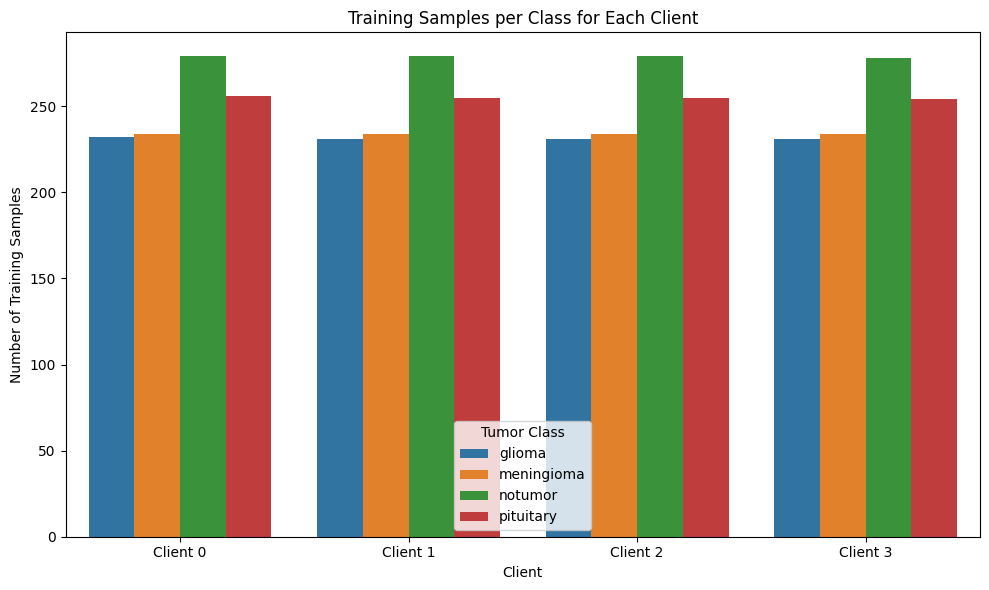

In [14]:
# --- Visualization: Training Samples per Class per Client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
data_plot = {'Client': [], 'Class': [], 'Count': []}

for cid, splits in ACTIVE_SPLITS.items():
    train_data = splits['train']
    label_counts = {lbl: 0 for lbl in CLASS_NAMES}
    for _, label in train_data:
        label_name = CLASS_NAMES[label] if isinstance(label, int) else label
        label_counts[label_name] += 1
    for lbl in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(lbl)
        data_plot['Count'].append(label_counts[lbl])

df_plot = pd.DataFrame(data_plot)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
plt.title('Training Samples per Class for Each Client')
plt.xlabel('Client')
plt.ylabel('Number of Training Samples')
plt.legend(title='Tumor Class')
plt.tight_layout()
plt.show()

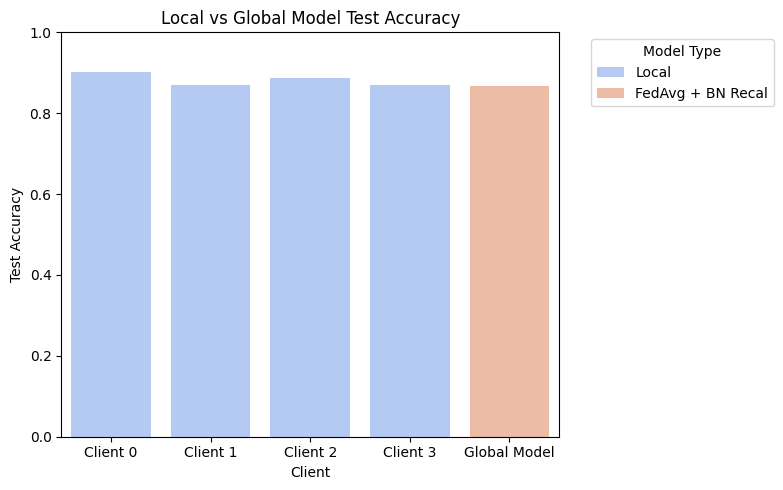

In [15]:
# Visualization: Local vs. Global Test Accuracies ---

# Collect results
results_summary = []

# Local clients
for cid, res in local_results.items():
    results_summary.append({
        'Client': f'Client {cid}',
        'Type': 'Local',
        'Accuracy': res['test_acc']
    })

# Global (after BN recalibration)
results_summary.append({
    'Client': 'Global Model',
    'Type': 'FedAvg + BN Recal',
    'Accuracy': g_acc_fix  # from your last BN recal output
})

df_acc = pd.DataFrame(results_summary)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='coolwarm')
plt.title('Local vs Global Model Test Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

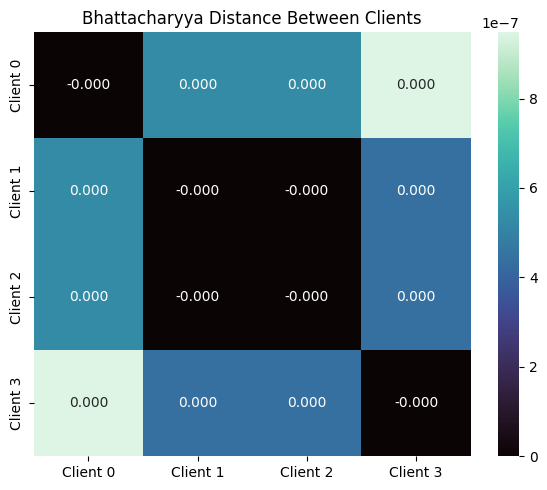

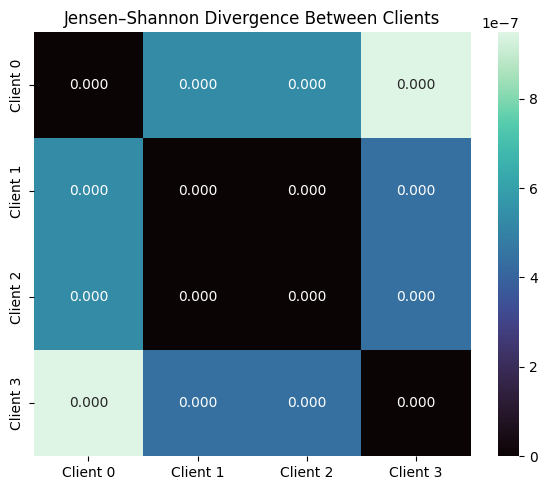

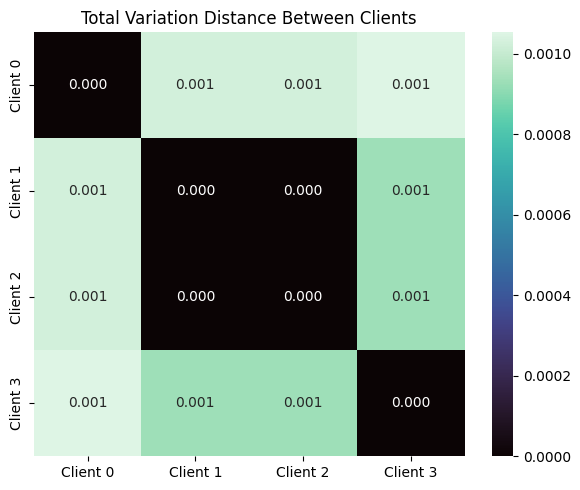

In [16]:
# --- Visualization: Client Distribution Divergence Heatmaps ---

import numpy as np
from scipy.stats import entropy

def get_class_distribution(client_data, class_labels):
    counts = {label: 0 for label in class_labels}
    for _, label in client_data:
        label_name = CLASS_NAMES[label] if isinstance(label, int) else label
        counts[label_name] += 1
    total = sum(counts.values())
    return np.array([counts[label] / total if total > 0 else 0 for label in class_labels])

def bhattacharyya_distance(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    bc = np.sum(np.sqrt(p * q))
    return -np.log(bc)

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def jensen_shannon_divergence(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def compute_divergence_matrix(clients_splits, class_labels):
    dists = []
    for cid, splits in clients_splits.items():
        dists.append(get_class_distribution(splits['train'], class_labels))
    n = len(dists)
    bhatt = np.zeros((n, n))
    jsd = np.zeros((n, n))
    tvd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            bhatt[i, j] = bhattacharyya_distance(dists[i], dists[j])
            jsd[i, j] = jensen_shannon_divergence(dists[i], dists[j])
            tvd[i, j] = total_variation_distance(dists[i], dists[j])
    return bhatt, jsd, tvd

bhatt, jsd, tvd = compute_divergence_matrix(ACTIVE_SPLITS, CLASS_NAMES)
client_labels = [f"Client {i}" for i in range(len(ACTIVE_SPLITS))]

def plot_heatmap(matrix, title):
    df = pd.DataFrame(matrix, index=client_labels, columns=client_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(bhatt, 'Bhattacharyya Distance Between Clients')
plot_heatmap(jsd, 'Jensen–Shannon Divergence Between Clients')
plot_heatmap(tvd, 'Total Variation Distance Between Clients')

### Personalization after the Global Model

In [17]:
# --- Personalization Phase (Client-specific fine-tuning) ---

import copy
from torch import optim
from tqdm import tqdm

def fine_tune_local_model(global_model, client_splits, epochs=2, lr=1e-4):
    """
    Fine-tune the global model on a client's local training data.
    Returns the personalized model and its test accuracy.
    """
    model = copy.deepcopy(global_model)
    model.to(device)
    model.train()

    # Use smaller LR and fewer epochs (since we’re just adapting)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Build loaders
    dl_train, dl_val, dl_test = make_client_loaders(client_splits, batch_size=32)

    # Fine-tune
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in tqdm(dl_train, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}", leave=False):
            if batch is None:
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"  → Client fine-tune epoch {epoch+1}: Loss = {running_loss/len(dl_train):.4f}")

    # Evaluate before and after fine-tuning
    model.eval()
    loss, acc = evaluate_model(model, dl_test, criterion)
    return model, acc


# Run personalization for all clients
personalized_results = {}
criterion = nn.CrossEntropyLoss()

print("=== PERSONALIZATION PHASE ===")
for cid, splits in ACTIVE_SPLITS.items():
    print(f"\n[Client {cid}]")
    personalized_model, acc_personalized = fine_tune_local_model(global_model, splits, epochs=2, lr=1e-4)

    # Compare with the global model (before personalization)
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    _, acc_global_before = evaluate_model(global_model, dl_test, criterion)

    personalized_results[cid] = {
        'before': acc_global_before,
        'after': acc_personalized
    }
    print(f"[Client {cid}] Before personalization: {acc_global_before:.4f} | After: {acc_personalized:.4f}")

=== PERSONALIZATION PHASE ===

[Client 0]


  → Client fine-tune epoch 1: Loss = 0.2474


  → Client fine-tune epoch 2: Loss = 0.1292
[Client 0] Before personalization: 0.9231 | After: 0.9545

[Client 1]


  → Client fine-tune epoch 1: Loss = 0.2396


  → Client fine-tune epoch 2: Loss = 0.1179
[Client 1] Before personalization: 0.9231 | After: 0.9510

[Client 2]


  → Client fine-tune epoch 1: Loss = 0.2280


  → Client fine-tune epoch 2: Loss = 0.1192
[Client 2] Before personalization: 0.9196 | After: 0.9720

[Client 3]


  → Client fine-tune epoch 1: Loss = 0.2546


  → Client fine-tune epoch 2: Loss = 0.1406
[Client 3] Before personalization: 0.9301 | After: 0.9476


## ## Training, Validation and Testing with Non-IID split (Non-Identical Distribution)

In [18]:
# Use the Non-IID client splits from the code earlier
ACTIVE_SPLITS = clients_noniid_splits  # Changed to Non-IDD split

from collections import Counter

# (Optional) quick sanity print of counts (no visualization)
print("=== Non-IID training distribution (counts) ===")
for cid, s in ACTIVE_SPLITS.items():
    c = Counter([CLASS_NAMES[y] for _, y in s['train']])
    print(f"Client {cid}: {len(s['train'])} train | per-class: {dict(c)}")

=== Non-IID training distribution (counts) ===
Client 0: 1298 train | per-class: {'pituitary': 326, 'meningioma': 305, 'glioma': 326, 'notumor': 341}
Client 1: 623 train | per-class: {'notumor': 192, 'meningioma': 158, 'pituitary': 215, 'glioma': 58}
Client 2: 1038 train | per-class: {'meningioma': 290, 'glioma': 274, 'notumor': 291, 'pituitary': 183}
Client 3: 1037 train | per-class: {'pituitary': 295, 'glioma': 266, 'meningioma': 184, 'notumor': 292}


In [19]:
# --- Train local models per client on Non-IID splits ---

local_results_noniid = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=2,               # adjust for speed/quality (e.g., 2 for quick test)
        batch_size=32,
        lr=1e-3,
        pretrained=True,
        freeze_backbone=False,  # set True for faster runs
        patience=2
    )
    local_results_noniid[cid] = res

print("\n=== Non-IID Local Test Accuracies ===")
for cid, r in local_results_noniid.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

[Client 0] Epoch 01 | Train L:0.5856 A:0.7874 | Val L:1.8796 A:0.5753 | 62.5s
[Client 0] Epoch 02 | Train L:0.3441 A:0.8775 | Val L:0.9878 A:0.7366 | 62.6s
[Client 0] Test  L:0.9799 A:0.7763
[Client 1] Epoch 01 | Train L:0.6188 A:0.7881 | Val L:0.8749 A:0.6854 | 30.6s
[Client 1] Epoch 02 | Train L:0.3498 A:0.8812 | Val L:0.7657 A:0.7079 | 30.6s
[Client 1] Test  L:0.6709 A:0.7809
[Client 2] Epoch 01 | Train L:0.6465 A:0.7678 | Val L:2.2297 A:0.6376 | 223.4s
[Client 2] Epoch 02 | Train L:0.3695 A:0.8863 | Val L:0.4565 A:0.8188 | 50.9s
[Client 2] Test  L:0.4677 A:0.8283
[Client 3] Epoch 01 | Train L:0.4929 A:0.8264 | Val L:0.9359 A:0.7718 | 49.7s
[Client 3] Epoch 02 | Train L:0.2913 A:0.8939 | Val L:1.1863 A:0.6980 | 50.7s
[Client 3] Test  L:0.9682 A:0.7811

=== Non-IID Local Test Accuracies ===
Client 0: Val* 0.7366 | Test 0.7763 | n_train=1298
Client 1: Val* 0.7079 | Test 0.7809 | n_train=623
Client 2: Val* 0.8188 | Test 0.8283 | n_train=1038
Client 3: Val* 0.7718 | Test 0.7811 | n_trai

In [20]:
# --- Aggregate (BN-safe FedAvg), recalibrate BN, and evaluate ---

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Build test loader once (global Testing set)
def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                         persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)

# BN-safe FedAvg (don’t average BN buffers; copy from largest client)
def fedavg_params_bnfix(global_model, client_state_and_sizes):
    gdict = global_model.state_dict()
    largest_idx = max(range(len(client_state_and_sizes)), key=lambda i: client_state_and_sizes[i][1])
    ref_state, _ = client_state_and_sizes[largest_idx]
    with torch.no_grad():
        # copy BN buffers from reference
        for k in gdict.keys():
            if ("running_mean" in k) or ("running_var" in k) or ("num_batches_tracked" in k):
                gdict[k].copy_(ref_state[k])
        # weighted average parameters
        total = sum(n for _, n in client_state_and_sizes)
        for k in gdict.keys():
            if ("running_mean" in k) or ("running_var" in k) or ("num_batches_tracked" in k):
                continue
            acc = torch.zeros_like(gdict[k])
            for state, n in client_state_and_sizes:
                acc.add_(state[k].to(acc.dtype), alpha=float(n))
            gdict[k].copy_(acc / max(total, 1))
    global_model.load_state_dict(gdict)
    return global_model

# BN recalibration (forward-only on mixed calibration set)
def make_calibration_loader(clients_splits, per_client=200, batch_size=64):
    cal_pairs = []
    for cid, splits in clients_splits.items():
        cal_pairs.extend(splits['train'][:min(per_client, len(splits['train']))])
    cal_ds = BrainTumorDataset(cal_pairs, transform=eval_tfms)
    return DataLoader(cal_ds, batch_size=batch_size, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)

@torch.no_grad()
def bn_recalibrate(model, cal_loader, max_batches=50):
    was_training = model.training
    model.train()
    seen = 0
    for batch in cal_loader:
        if batch is None: continue
        x, _ = batch
        _ = model(x.to(device))  # updates BN running stats
        seen += 1
        if seen >= max_batches: break
    model.train(was_training)

# Build & aggregate
criterion = nn.CrossEntropyLoss()
global_model_noniid = build_global_model(pretrained=True)  # same policy as locals

client_state_and_sizes = [(res["best_state"], res["train_samples"])
                          for cid, res in local_results_noniid.items()]
global_model_noniid = fedavg_params_bnfix(global_model_noniid, client_state_and_sizes)

# Recalibrate BN on mixed Non-IID data
cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)
bn_recalibrate(global_model_noniid, cal_loader, max_batches=50)

# Evaluate global (Testing) + per-client tests
g_loss, g_acc = evaluate_model(global_model_noniid, test_loader, criterion)
print(f"\n[Non-IID Global FedAvg (BN-safe) + BN Recal]  Test Loss: {g_loss:.4f} | Test Acc: {g_acc:.4f}")

for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model_noniid, dl_test, criterion)
    print(f"[Global on Client {cid} test] Acc {acc:.4f}")



[Non-IID Global FedAvg (BN-safe) + BN Recal]  Test Loss: 0.7885 | Test Acc: 0.7033
[Global on Client 0 test] Acc 0.7170
[Global on Client 1 test] Acc 0.6798
[Global on Client 2 test] Acc 0.7677
[Global on Client 3 test] Acc 0.7037


### Vistualization of results and testing (Non-IID Split)

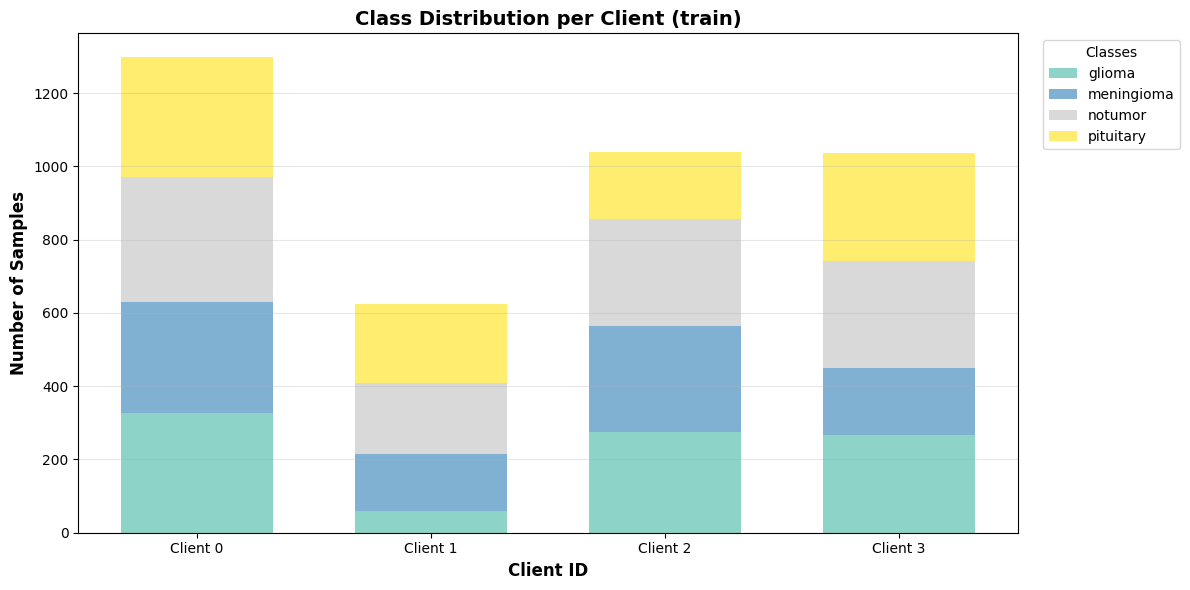

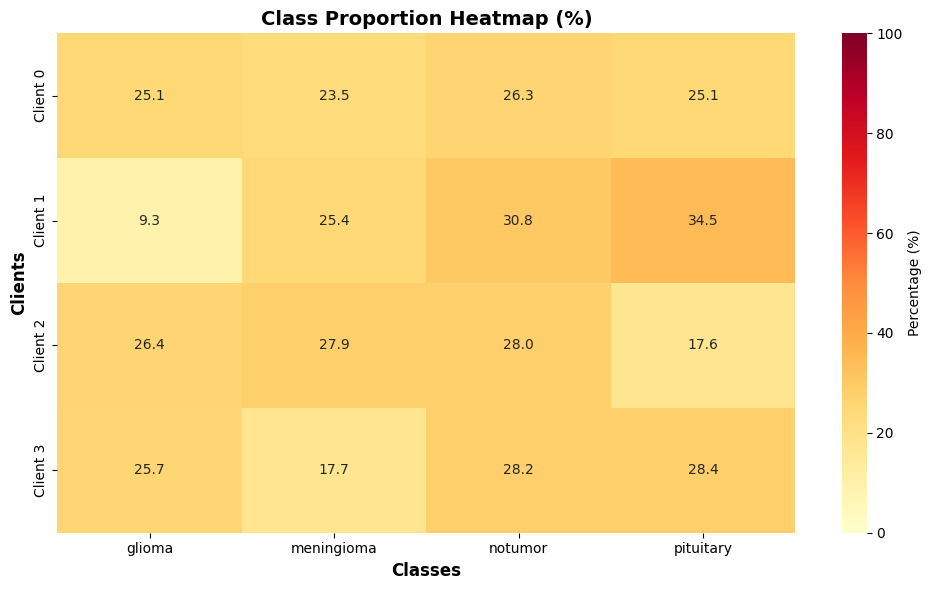

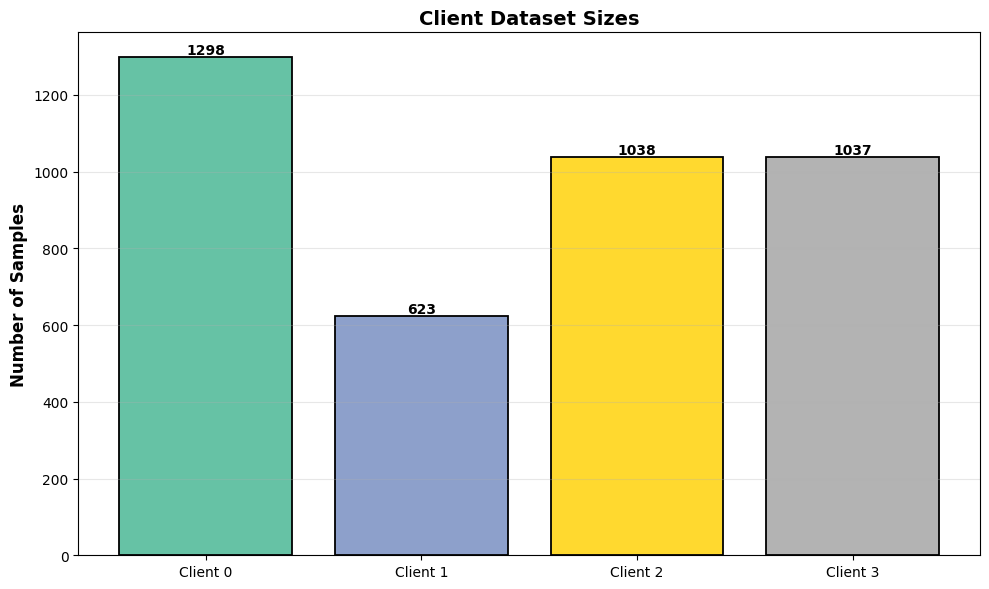

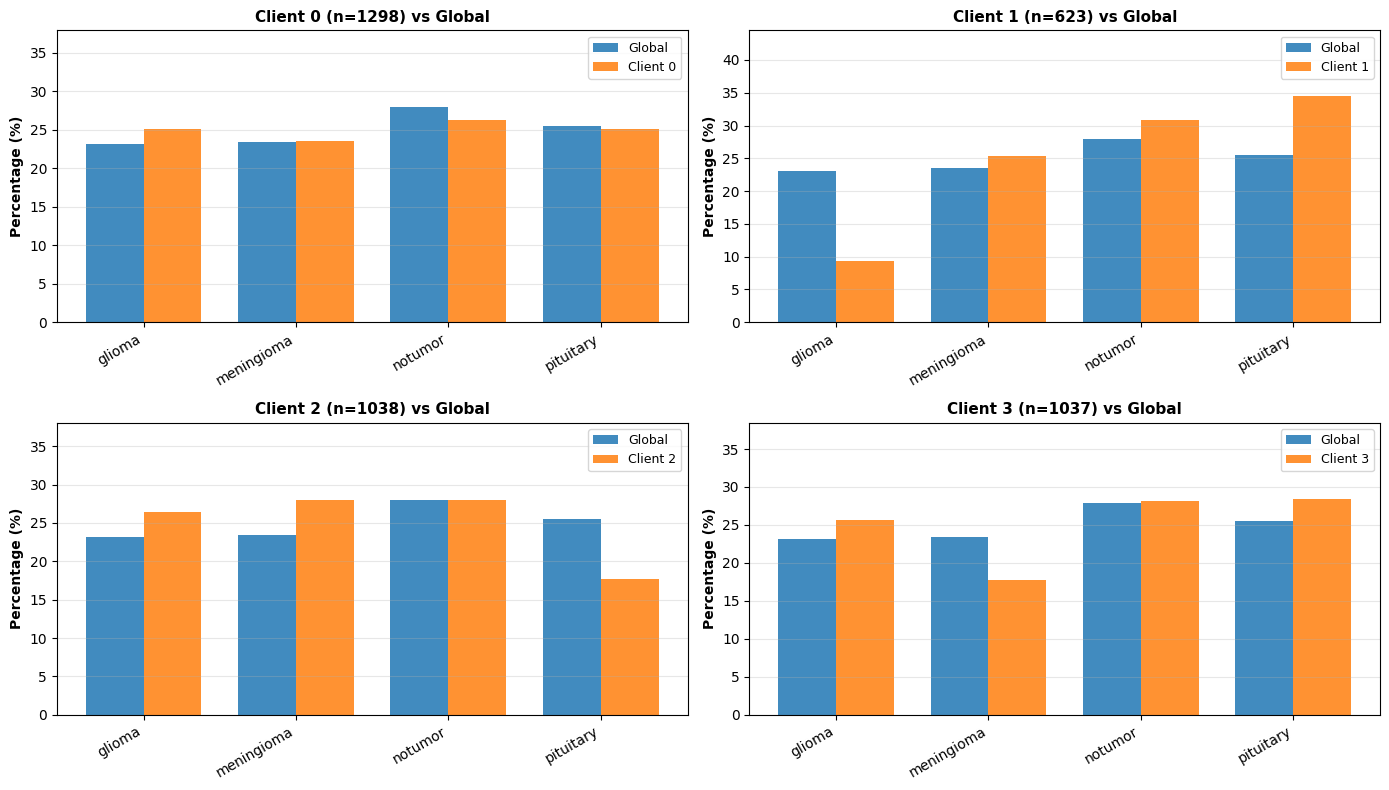


SUMMARY for subset: train

Client 0: 1298 samples
  glioma      :   326  ( 25.1%)
  meningioma  :   305  ( 23.5%)
  notumor     :   341  ( 26.3%)
  pituitary   :   326  ( 25.1%)

Client 1: 623 samples
  glioma      :    58  (  9.3%)
  meningioma  :   158  ( 25.4%)
  notumor     :   192  ( 30.8%)
  pituitary   :   215  ( 34.5%)

Client 2: 1038 samples
  glioma      :   274  ( 26.4%)
  meningioma  :   290  ( 27.9%)
  notumor     :   291  ( 28.0%)
  pituitary   :   183  ( 17.6%)

Client 3: 1037 samples
  glioma      :   266  ( 25.7%)
  meningioma  :   184  ( 17.7%)
  notumor     :   292  ( 28.2%)
  pituitary   :   295  ( 28.4%)

Global Distribution:
  glioma      :   924  ( 23.1%)
  meningioma  :   937  ( 23.4%)
  notumor     :  1116  ( 27.9%)
  pituitary   :  1019  ( 25.5%)

Sanity check messages:
  [WARN] Client 1: 'notumor' is NOT the top class (top=pituitary).
  [WARN] Client 3: 'notumor' is NOT the top class (top=pituitary).


In [21]:
# Vistualization on data distribution

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import math

# Optional seaborn heatmap; will fallback to matplotlib if unavailable
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# -----------------------------
# 0) Pick your source
# -----------------------------
# If you have per-client splits:
#   clients_source = clients_noniid_splits   # dict[cid] -> {'train','val','test': list[(path,label)]}
# Otherwise (no splits, just pairs):
#   clients_source = clients_noniid          # dict[cid] -> list[(path,label)]
clients_source = clients_noniid_splits  # <<< change to clients_noniid if needed

# Which subset to visualize when splits exist: 'train' | 'val' | 'test'
subset = 'train'

# CLASS_NAMES must exist (e.g., ["glioma","meningioma","notumor","pituitary"])
classes = list(CLASS_NAMES)
num_classes = len(classes)

# -----------------------------
# 1) Normalize to {cid: list[(path,label)]} according to chosen subset
# -----------------------------
def _pairs_for_client(entry):
    if isinstance(entry, dict):
        # split dict
        return entry.get(subset, [])
    # already a list of (path,label)
    return entry

clients = sorted(clients_source.keys())
client_pairs = {cid: _pairs_for_client(clients_source[cid]) for cid in clients}

# -----------------------------
# 2) Count per-class for each client + global
# -----------------------------
client_class_dist = {}
global_dist = Counter()

for cid in clients:
    cnt = Counter(lbl for _, lbl in client_pairs[cid])
    client_class_dist[cid] = cnt
    global_dist.update(cnt)

total_samples = sum(global_dist.values())
global_percentages = np.array([
    (global_dist.get(ci, 0) / total_samples * 100.0) if total_samples else 0.0
    for ci in range(num_classes)
])

# Identify the "notumor" class id robustly
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_percentages))
tumor_ids = [i for i in range(num_classes) if i != notumor_id]

# -----------------------------
# 3) Stacked bar: counts per class per client
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(clients))
width = 0.65
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[cid].get(class_idx, 0) for cid in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title(f"Class Distribution per Client ({subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'})",
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 4) Heatmap: % per class per client
# -----------------------------
heatmap_data = []
for cid in clients:
    row_counts = [client_class_dist[cid].get(ci, 0) for ci in range(num_classes)]
    tot = sum(row_counts)
    row_pct = [(c / tot * 100.0) if tot else 0.0 for c in row_counts]
    heatmap_data.append(row_pct)

heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
if _HAS_SNS:
    sns.heatmap(
        heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        xticklabels=classes,
        yticklabels=[f"Client {k}" for k in clients],
        ax=ax, vmin=0, vmax=max(100, math.ceil(heatmap_data.max()))
    )
else:
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(100, math.ceil(heatmap_data.max())))
    ax.set_xticks(np.arange(num_classes)); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(clients))); ax.set_yticklabels([f"Client {k}" for k in clients])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)')
    # annotate
    for i in range(len(clients)):
        for j in range(num_classes):
            ax.text(j, i, f"{heatmap_data[i,j]:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 5) Client sizes (bar + labels)
# -----------------------------
client_sizes = [len(client_pairs[cid]) for cid in clients]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=plt.cm.Set2(np.linspace(0,1,len(clients))),
              edgecolor='black', linewidth=1.3)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Client vs Global (percentages)
# -----------------------------
rows = math.ceil(len(clients)/2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, cid in enumerate(clients):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    client_total = len(client_pairs[cid])
    client_percentages = np.array([
        (client_class_dist[cid].get(ci, 0) / client_total * 100.0) if client_total else 0.0
        for ci in range(num_classes)
    ])
    xpos = np.arange(num_classes)
    w = 0.38
    ax.bar(xpos - w/2, global_percentages, w, label='Global', alpha=0.85)
    ax.bar(xpos + w/2, client_percentages, w, label=f'Client {cid}', alpha=0.85)
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {cid} (n={client_total}) vs Global', fontsize=11, fontweight='bold')
    ax.set_xticks(xpos)
    ax.set_xticklabels(classes, rotation=30, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ymax = max(global_percentages.max(), client_percentages.max()) + 10
    ax.set_ylim([0, min(100, ymax)])
# hide empty subplots if any
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
#plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 7) Summary + sanity checks
# -----------------------------
print("\n" + "="*72)
print(f"SUMMARY for subset: {subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'}")
print("="*72)

warns = []
for cid in clients:
    n = len(client_pairs[cid])
    print(f"\nClient {cid}: {n} samples")
    for ci, cname in enumerate(classes):
        cnt = client_class_dist[cid].get(ci, 0)
        pct = (cnt / n * 100.0) if n else 0.0
        print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")

    # check: notumor highest
    counts = {ci: client_class_dist[cid].get(ci, 0) for ci in range(num_classes)}
    top_lbl = max(counts, key=counts.get) if counts else None
    if top_lbl != notumor_id:
        warns.append(f"[WARN] Client {cid}: '{classes[notumor_id]}' is NOT the top class (top={classes[top_lbl]}).")

print("\n" + "="*72)
print("Global Distribution:")
print("="*72)
for ci, cname in enumerate(classes):
    cnt = global_dist.get(ci, 0)
    pct = (cnt / total_samples * 100.0) if total_samples else 0.0
    print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")
print("="*72)

if warns:
    print("\nSanity check messages:")
    for w in warns:
        print(" ", w)

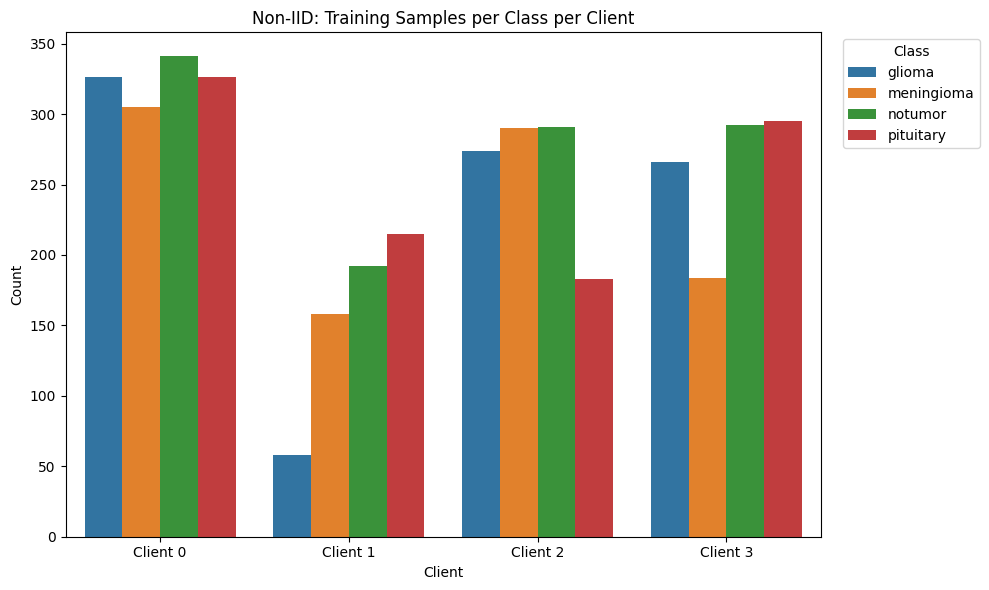

In [22]:
# --- Non-IID — training samples per class per client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

data_plot = {'Client': [], 'Class': [], 'Count': []}
for cid, splits in ACTIVE_SPLITS.items():
    counts = Counter(CLASS_NAMES[y] for _, y in splits['train'])
    for cls in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(cls)
        data_plot['Count'].append(counts.get(cls, 0))

df_plot = pd.DataFrame(data_plot)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
ax.set_title('Non-IID: Training Samples per Class per Client')
ax.set_xlabel('Client'); ax.set_ylabel('Count')
ax.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

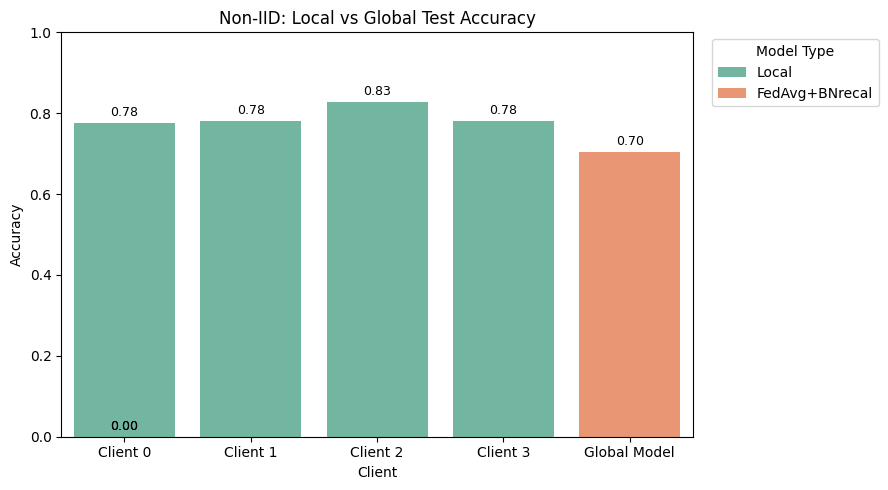

In [23]:
# --- Non-IID — Local vs Global accuracies ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_acc = pd.DataFrame(
    [{'Client': f'Client {cid}', 'Type': 'Local', 'Accuracy': r['test_acc']}
     for cid, r in local_results_noniid.items()] +
    [{'Client': 'Global Model', 'Type': 'FedAvg+BNrecal', 'Accuracy': g_acc}]
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='Set2')
ax.set_title('Non-IID: Local vs Global Test Accuracy')
ax.set_ylim(0, 1); ax.set_ylabel('Accuracy')
ax.legend(title='Model Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# annotate bars with values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()

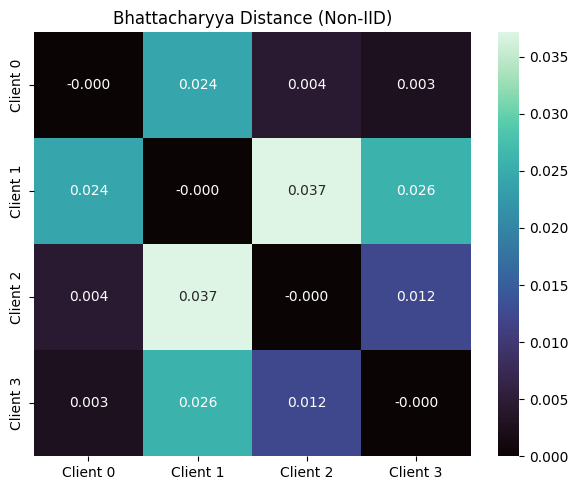

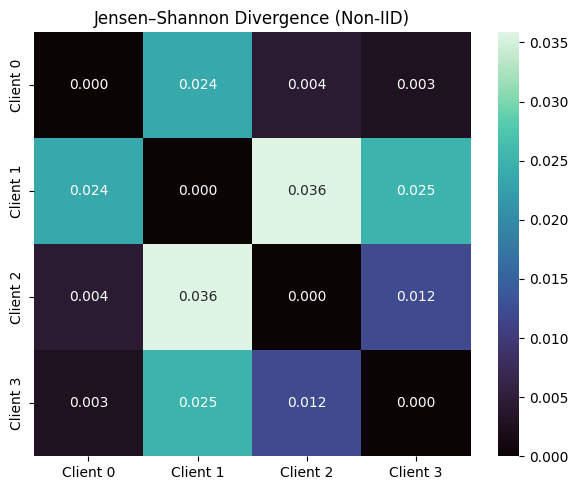

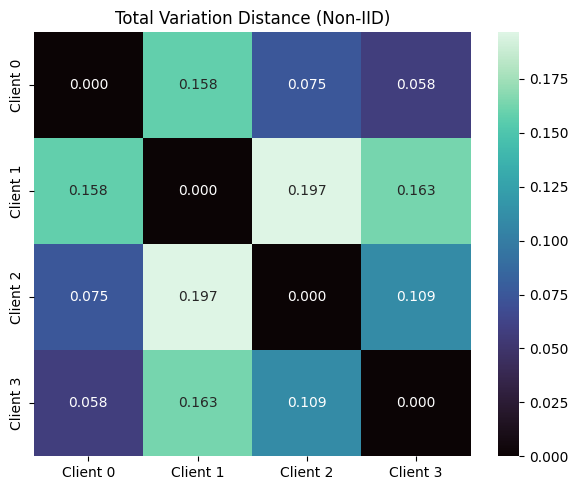

In [24]:
# --- Non-IID — divergence between client class distributions ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def dist_vec(pairs):
    counts = {cls: 0 for cls in CLASS_NAMES}
    for _, y in pairs:
        counts[CLASS_NAMES[y]] += 1
    total = sum(counts.values())
    return np.array([counts[c]/total if total else 0 for c in CLASS_NAMES], dtype=float)

def bhattacharyya_distance(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    return -np.log(np.sum(np.sqrt(p*q)))

def total_variation_distance(p, q):
    return 0.5*np.sum(np.abs(p-q))

def jensen_shannon_divergence(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    m = 0.5*(p+q)
    return 0.5*entropy(p, m) + 0.5*entropy(q, m)

vecs = [dist_vec(s['train']) for _, s in ACTIVE_SPLITS.items()]
n = len(vecs)
bh = np.zeros((n, n)); jsd = np.zeros((n, n)); tvd = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        bh[i,j]  = bhattacharyya_distance(vecs[i], vecs[j])
        jsd[i,j] = jensen_shannon_divergence(vecs[i], vecs[j])
        tvd[i,j] = total_variation_distance(vecs[i], vecs[j])

labels = [f"Client {i}" for i in range(n)]

def plot_hm(M, title):
    df = pd.DataFrame(M, index=labels, columns=labels)
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    ax.set_title(title)
    plt.tight_layout(); plt.show()

plot_hm(bh,  'Bhattacharyya Distance (Non-IID)')
plot_hm(jsd, 'Jensen–Shannon Divergence (Non-IID)')
plot_hm(tvd, 'Total Variation Distance (Non-IID)')

<Figure size 600x600 with 0 Axes>

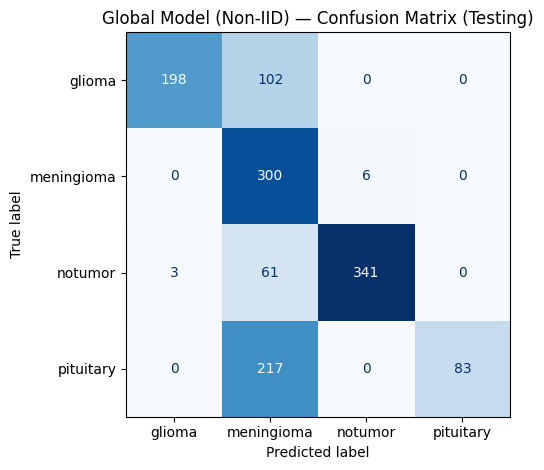

In [25]:
# --- Non-IID — Global model confusion matrix on Testing ---

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

y_true, y_pred = [], []
global_model_noniid.eval()
with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        x, y = batch
        logits = global_model_noniid(x.to(device))
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
plt.figure(figsize=(6,6))
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title('Global Model (Non-IID) — Confusion Matrix (Testing)')
plt.tight_layout()
plt.show()

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Global Distribution (proportions): [0.2312 0.2345 0.2793 0.255 ]

=== DIVERGENCE vs GLOBAL ===
Client 0: JS=0.0184 | KL=0.0014 | Wasserstein=0.0442 | Hellinger=0.0184
Client 1: JS=0.1383 | KL=0.0873 | Wasserstein=0.3472 | Hellinger=0.1392
Client 2: JS=0.0717 | KL=0.0214 | Wasserstein=0.1891 | Hellinger=0.0717
Client 3: JS=0.0521 | KL=0.0112 | Wasserstein=0.0865 | Hellinger=0.0521

Averages:  JS=0.0701 | KL=0.0303 | Wasserstein=0.1668 | Hellinger=0.0704


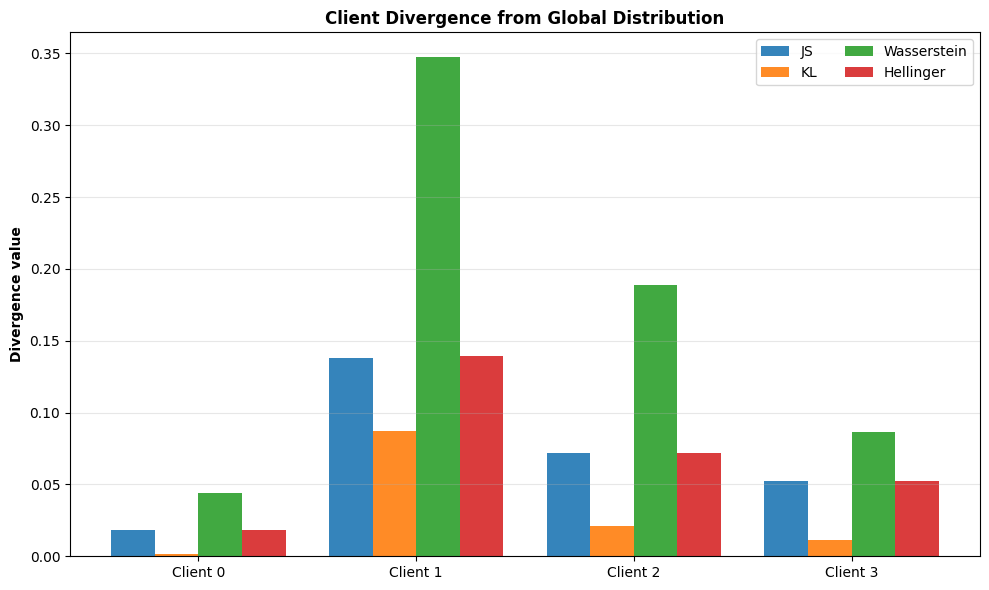

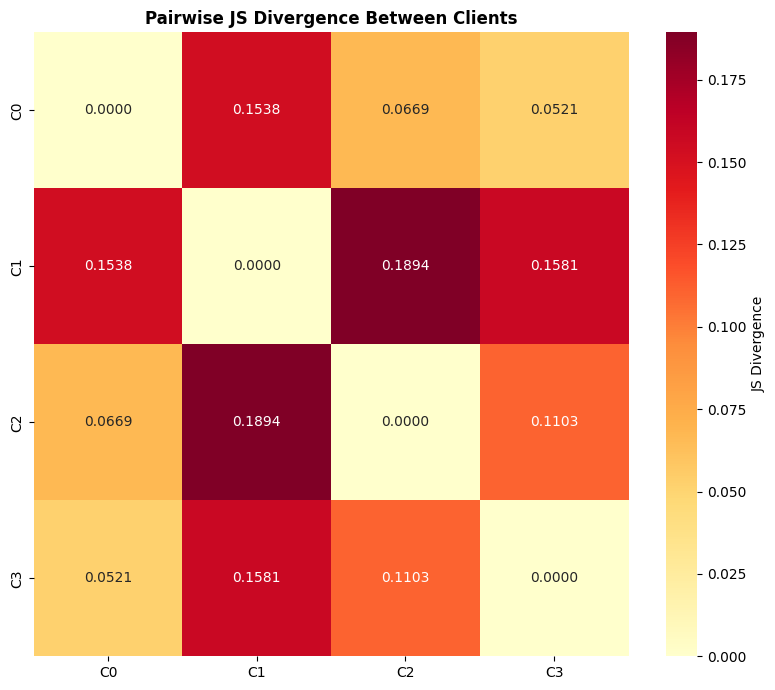


Divergence summary:
   Client  JS_Divergence  KL_Divergence  Wasserstein_Distance  Hellinger_Distance  Client_Size
Client 0       0.018436       0.001354              0.044191            0.018437       1298.0
Client 1       0.138298       0.087317              0.347239            0.139240        623.0
Client 2       0.071657       0.021356              0.189079            0.071734       1038.0
Client 3       0.052099       0.011201              0.086519            0.052132       1037.0
 Average       0.070122       0.030307              0.166757            0.070385        999.0

✅ Saved CSV: divergence_metrics.csv

No-tumor % per client: ['26.27%', '30.82%', '28.03%', '28.16%']

Sanity warnings:
  [WARN] Client 1: 'notumor' is NOT top (top=pituitary).
  [WARN] Client 3: 'notumor' is NOT top (top=pituitary).


In [26]:
#Showing Divergence among clients

from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, wasserstein_distance

clients_source = clients_noniid_splits   # <<< change to clients_noniid if needed
subset = 'train'                         # <<< ignored if using clients_noniid

classes = list(CLASS_NAMES)
num_classes = len(classes)

def _pairs_for_client(entry, subset):
    if isinstance(entry, dict):
        return entry.get(subset, [])
    return entry

clients = sorted(clients_source.keys())
NUM_CLIENTS = len(clients)

# =========================
# 1) Build distributions
# =========================
EPS = 1e-12  # smoothing to avoid zeros in KL, Hellinger, etc.

client_distributions = {}
client_sizes = {}
for k in clients:
    pairs = _pairs_for_client(clients_source[k], subset)
    counts = np.zeros(num_classes, dtype=float)
    for _, lbl in pairs:
        counts[int(lbl)] += 1.0
    client_sizes[k] = int(counts.sum())
    p = counts + EPS
    p = p / p.sum()
    client_distributions[k] = p

# Global distribution from all clients (same subset)
global_counts = np.zeros(num_classes, dtype=float)
for k in clients:
    global_counts += client_distributions[k] * max(client_sizes[k], 0)  # undo prob -> weighted sum
global_total = global_counts.sum()
global_dist = (global_counts + EPS) / (global_total + EPS * num_classes)

print("Classes:", classes)
print("Global Distribution (proportions):", np.round(global_dist, 4))

# =========================
# 2) Divergence metrics
# =========================
js_divergences = {}
kl_divergences = {}
hellinger_dists = {}
wasserstein_dists = {}

def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# For categorical Wasserstein, use class indices as positions + probabilities as weights
class_positions = np.arange(num_classes, dtype=float)

for k in clients:
    p = client_distributions[k]
    # JS (already sqrt(JS divergence) from scipy; squared is common, but we'll keep the conventional output)
    js_divergences[k] = float(jensenshannon(global_dist, p))
    # KL (global || client): use natural log
    kl_divergences[k] = float(entropy(global_dist, p))
    # Hellinger
    hellinger_dists[k] = float(hellinger_distance(global_dist, p))
    # Wasserstein for categorical distributions
    # scipy's wasserstein_distance supports weights over numeric positions
    wasserstein_dists[k] = float(wasserstein_distance(class_positions, class_positions,
                                                      u_weights=global_dist, v_weights=p))

avg_js = float(np.mean(list(js_divergences.values())))
avg_kl = float(np.mean(list(kl_divergences.values())))
avg_hellinger = float(np.mean(list(hellinger_dists.values())))
avg_wasserstein = float(np.mean(list(wasserstein_dists.values())))

print("\n=== DIVERGENCE vs GLOBAL ===")
for k in clients:
    print(f"Client {k}: JS={js_divergences[k]:.4f} | KL={kl_divergences[k]:.4f} | "
          f"Wasserstein={wasserstein_dists[k]:.4f} | Hellinger={hellinger_dists[k]:.4f}")
print(f"\nAverages:  JS={avg_js:.4f} | KL={avg_kl:.4f} | "
      f"Wasserstein={avg_wasserstein:.4f} | Hellinger={avg_hellinger:.4f}")

# =========================
# 3) Pairwise JS (client↔client)
# =========================
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS), dtype=float)
for i, ki in enumerate(clients):
    for j, kj in enumerate(clients):
        if j <= i: 
            continue
        d = float(jensenshannon(client_distributions[ki], client_distributions[kj]))
        pairwise_js[i, j] = d
        pairwise_js[j, i] = d

# =========================
# 4) Visualizations
# =========================
# Plot A: Divergence from Global
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(NUM_CLIENTS)
width = 0.2
ax.bar(x - 1.5*width, [js_divergences[k] for k in clients], width, label='JS', alpha=0.9)
ax.bar(x - 0.5*width, [kl_divergences[k] for k in clients], width, label='KL', alpha=0.9)
ax.bar(x + 0.5*width, [wasserstein_dists[k] for k in clients], width, label='Wasserstein', alpha=0.9)
ax.bar(x + 1.5*width, [hellinger_dists[k] for k in clients], width, label='Hellinger', alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.set_ylabel("Divergence value", fontweight='bold')
ax.set_title("Client Divergence from Global Distribution", fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.legend(ncol=2)
plt.tight_layout()
#plt.savefig("divergence_from_global.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot B: Pairwise JS heatmap
try:
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
                xticklabels=[f"C{k}" for k in clients],
                yticklabels=[f"C{k}" for k in clients],
                cbar_kws={'label': 'JS Divergence'}, ax=ax)
    ax.set_title("Pairwise JS Divergence Between Clients", fontweight='bold')
    plt.tight_layout()
    plt.savefig("pairwise_divergence_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
except Exception:
    # Fallback plain matplotlib
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(pairwise_js, cmap='YlOrRd')
    ax.set_xticks(x); ax.set_yticks(x)
    ax.set_xticklabels([f"C{k}" for k in clients])
    ax.set_yticklabels([f"C{k}" for k in clients])
    for i in range(NUM_CLIENTS):
        for j in range(NUM_CLIENTS):
            ax.text(j, i, f"{pairwise_js[i, j]:.4f}", ha='center', va='center', fontsize=8)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label('JS Divergence')
    ax.set_title("Pairwise JS Divergence Between Clients", fontweight='bold')
    plt.tight_layout()
    #plt.savefig("pairwise_divergence_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

# =========================
# 5) Summary table + CSV
# =========================
divergence_df = pd.DataFrame({
    'Client': [f'Client {k}' for k in clients] + ['Average'],
    'JS_Divergence': [js_divergences[k] for k in clients] + [avg_js],
    'KL_Divergence': [kl_divergences[k] for k in clients] + [avg_kl],
    'Wasserstein_Distance': [wasserstein_dists[k] for k in clients] + [avg_wasserstein],
    'Hellinger_Distance': [hellinger_dists[k] for k in clients] + [avg_hellinger],
    'Client_Size': [client_sizes[k] for k in clients] + [sum(client_sizes.values())/NUM_CLIENTS]
})
print("\nDivergence summary:\n", divergence_df.to_string(index=False))

#divergence_df.to_csv("divergence_metrics.csv", index=False)
print("\n✅ Saved CSV: divergence_metrics.csv")

# =========================
# 6) Optional: verify 'notumor' dominance & similarity
# =========================
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_dist))

nt_pcts = []
warnings = []
for k in clients:
    p = client_distributions[k]
    top = int(np.argmax(p))
    if top != notumor_id:
        warnings.append(f"[WARN] Client {k}: '{classes[notumor_id]}' is NOT top (top={classes[top]}).")
    nt_pcts.append(p[notumor_id]*100)

print("\nNo-tumor % per client:", [f"{v:.2f}%" for v in nt_pcts])
if warnings:
    print("\nSanity warnings:")
    for w in warnings:
        print(" ", w)

# Non-IDD with FedProx

In [27]:
# ---------- Run local training for all 4 clients (FedProx) ----------
# Uses the same dataset/loaders/utilities you already have:
# - build_global_model, BrainTumorDataset, drop_bad_collate, device, etc.

import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Proximal helper: sum of squared L2 distances between local and global parameters
def _proximal_term(local_model, global_state):
    prox = 0.0
    for (name, p_local) in local_model.named_parameters():
        if not p_local.requires_grad:
            continue
        p_global = global_state[name].to(p_local.device)
        prox += torch.sum((p_local - p_global) ** 2)
    return prox

def train_local_one_client_prox(
    client_id,
    client_splits,
    epochs=5,
    batch_size=32,
    lr=1e-3,
    pretrained=True,
    freeze_backbone=False,
    patience=2,
    global_state=None,    # REQUIRED for FedProx
    mu=0.01               # proximal strength (μ/2)*||w - w_global||^2
):
    assert global_state is not None, "FedProx needs the current global_state."

    # Build & init the model from global state
    model = build_global_model(num_classes=NUM_CLASSES, pretrained=pretrained)
    model.load_state_dict(global_state)
    model.to(device)

    if freeze_backbone:
        for n, p in model.named_parameters():
            if not n.startswith('fc.'):  # keep only final layer trainable
                p.requires_grad = False

    # Dataloaders
    train_pairs = client_splits['train']
    val_pairs   = client_splits['val']
    test_pairs  = client_splits['test']

    train_ds = BrainTumorDataset(train_pairs, transform=train_tfms)
    val_ds   = BrainTumorDataset(val_pairs,   transform=eval_tfms)
    test_ds  = BrainTumorDataset(test_pairs,  transform=eval_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=0 if device.type=="cpu" else 4,
                              pin_memory=(device.type=="cuda"),
                              persistent_workers=(device.type=="cuda"),
                              collate_fn=drop_bad_collate)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=0 if device.type=="cpu" else 4,
                            pin_memory=(device.type=="cuda"),
                            persistent_workers=(device.type=="cuda"),
                            collate_fn=drop_bad_collate)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=0 if device.type=="cpu" else 4,
                             pin_memory=(device.type=="cuda"),
                             persistent_workers=(device.type=="cuda"),
                             collate_fn=drop_bad_collate)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Early stopping
    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = -1.0
    no_improve = 0

    # Training loop with proximal term
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            if batch is None:  # drop_bad_collate safeguard
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss_ce = criterion(logits, y)

            # FedProx proximal regularizer
            prox = _proximal_term(model, global_state)
            loss = loss_ce + (mu / 2.0) * prox

            loss.backward()
            optimizer.step()

        # ---- validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # Final test with best state
    model.load_state_dict(best_state)
    test_loss, test_acc = evaluate_model(model, test_loader, criterion)

    return {
        "client_id": client_id,
        "best_state": best_state,            # to be sent to server
        "val_best_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "train_samples": len(train_ds)
    }

# ---- Choose which split to use (same toggle as your FedAvg) ----
# ACTIVE_SPLITS = clients_iid_splits
ACTIVE_SPLITS = clients_noniid_splits   # e.g., to test Non-IID

# ---- Run local FedProx training on all clients ----
mu = 0.01  # start small; try 0.005–0.05 in sweeps
EPOCHS = 5

# Initialize the current global from scratch (or reuse from a previous round)
current_global = build_global_model(num_classes=NUM_CLASSES, pretrained=True).state_dict()

local_results = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client_prox(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=EPOCHS,
        batch_size=32,
        lr=1e-3,
        pretrained=True,
        freeze_backbone=False,
        patience=2,
        global_state=current_global,
        mu=mu
    )
    local_results[cid] = res

print("\nSummary (FedProx, best Val Acc / Test Acc):")
for cid, r in local_results.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")


Summary (FedProx, best Val Acc / Test Acc):
Client 0: Val* 0.8925 | Test 0.8895 | n_train=1298
Client 1: Val* 0.9551 | Test 0.8989 | n_train=623
Client 2: Val* 0.8255 | Test 0.8418 | n_train=1038
Client 3: Val* 0.8725 | Test 0.8889 | n_train=1037


In [28]:
# ---------- FedProx aggregation (same as FedAvg) and global evaluation ----------

# 1) Pack client best states and sample sizes
client_state_and_sizes = []
for cid, res in local_results.items():
    client_state_and_sizes.append((res["best_state"], res["train_samples"]))

# 2) Build global model and aggregate with FedAvg rule
global_model = build_global_model(pretrained=True)
global_model = fedavg_weighted(global_model, client_state_and_sizes)

# 3) Evaluate on your held-out Testing set
criterion = nn.CrossEntropyLoss()

def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False,
                         num_workers=0 if device.type=="cpu" else 4,
                         pin_memory=(device.type=="cuda"),
                         persistent_workers=(device.type=="cuda"),
                         collate_fn=drop_bad_collate)

g_loss, g_acc = evaluate_model(global_model, test_loader, criterion)
print(f"[Global FedProx] Test Loss: {g_loss:.4f}  |  Test Acc: {g_acc:.4f}")

[Global FedProx] Test Loss: 0.4640  |  Test Acc: 0.8330
